

# Project: Investigate FBI Gun Data


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<ul>
    <li><a href='#Q1'>Q1: NICS checks at US level</a></li>
    <li><a href='#Q2'>Q2: NICS checks at state level</a></li>
    <li><a href='#Q3'>Q3: NICS checks at state level / pattern exploration</a></li>
    <li><a href='#Q4'>Q4: Correlation with census data</a></li>
    <li><a href='#Q5'>Q5: NICS checks normalized by population</a></li>
</ul>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#summary">Summary</a></li>
</ul>

<a id='intro'></a>
## Introduction

The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used by to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from census.gov.
- The NICS data is found in one sheet of an .xlsx file. It contains the number of firearm checks by month, state, and type.
- The U.S. census data is found in a .csv file. It contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.

<A href='https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md'>README</A> from the github repository provides more information on NICS firearm background checks and usefull links:

In particular, <A href="https://www.fbi.gov/file-repository/nics-firearms-licensee-manual-111811.pdf/view">this document</A> issued by FBI is usefull to understand the politic background (Brad act) and what are the different categories of NICS checks. Some instructive quotes:
- A request for a NICS check must be made prior to the transfer of a firearm to an unlicensed individual for both a sale and a pawn redemption
- A NICS check is not required if a transferee presents a valid Permit to Carry issued through the state POC that the ATF has indicated satisfies the provisions for the permit exception included in the Brady Act.

Some other usefull ressources used for this study:
- Gun laws per states: 
    - wikipedia https://en.wikipedia.org/wiki/Gun_laws_in_the_United_States_by_state
    - interactive map from theguardian https://www.theguardian.com/world/interactive/2013/jan/15/gun-laws-united-states
    - detailed study https://everytownresearch.org/navigator/states.html?dataset=background_checks&states=NY
- NY times article https://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html, and how they estimated gun sales based on NICS records https://github.com/NYTimes/gunsales#getting-gun-sales-estimates-from-background-checks <I>To convert background checks into estimated sales, we relied on a method suggested in the Small Arms Survey by Jurgen Brauer, a professor at Georgia Regents University. Each long gun and handgun check was counted as 1.1 sales. Each multiple-gun check was counted as two sales. Permit checks and other types of checks were omitted. The multiplier is an estimate based on Mr. Brauer's interviews with gun shop owners. Note: In our computation, we excluded background checks for the "multiple" category in California because they followed an unusual pattern that did not match California gun sales data.</I>
- Some others links are quoted in-line in the analysis

### Questions and fields to be explored

#### Q1  NICS checks at US level
- General trend of totals NICS checks
- Seasonal variation
- Trend per category
- NY time gun sales estimator
- Repartition per categories

#### Q2  NICS checks at state level
- General trend
- Repartition per categories
-  Which states have had the highest growth in gun registrations?

#### Q3  NICS checks at state level - patterns exploration
- Can we identify patterns in relation with state gun laws?
 
#### Q4 Correlation with census data?
- What census data is most associated with high gun per capital?

#### Q5 NICS checks normalized per population



In [504]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec

import seaborn as sns
%matplotlib inline

import wrangle as wg

<a id='wrangling'></a>
## Data Wrangling

> **note**: all wrangling procedures are gathered into wrangle.py for sake of readability

### General Properties

In [505]:
# Procedure 'read_census_data' does the following:
# - drop 'Fact Note' column, 'FICS code' row and foot notes
# - clean & convert all data to float values (D,Z,FN are set to 0)
# - Set index as 'Fact'
# - Parse 'Fact' column to retrieve start, end dates of the period and unit of the statistic
#   These information are available in the last three rows of the data frame (see tail below)
# - Transpose the dataframe: states are rows which is is consistent with guns_data
census_data_df=wg.read_census_data('./data/u.s.-census-data.csv')
census_data_df.head(2)

Conversion error:  D => set to 0
Conversion error:  D => set to 0
Conversion error:  Z => set to 0
Conversion error:  Z => set to 0
Conversion error:  Z => set to 0
Conversion error:  Z => set to 0
Conversion error:  FN => set to 0


Fact    Population estimates, July 1, 2016,  (V2016)  \
Alabama                                   4863300.00   
Alaska                                     741894.00   

Fact    Population estimates base, April 1, 2010,  (V2016)  \
Alabama                                         4780131.00   
Alaska                                           710249.00   

Fact    Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)  \
Alabama                                               0.02                                      
Alaska                                                0.04                                      

Fact    Population, Census, April 1, 2010  \
Alabama                        4779736.00   
Alaska                          710231.00   

Fact    Persons under 5 years, percent, July 1, 2016,  (V2016)  \
Alabama                                               0.06       
Alaska                                                0.07       

Fact    Persons under 5 years, percent, April 1, 2010  \
Alabama                                          0.06   
Alaska                                           0.08   

Fact    Persons under 18 years, percent, July 1, 2016,  (V2016)  \
Alabama                                               0.23        
Alaska                                                0.25        

Fact    Persons under 18 years, percent, April 1, 2010  \
Alabama                                           0.24   
Alaska                                            0.26   

Fact    Persons 65 years and over, percent,  July 1, 2016,  (V2016)  \
Alabama                                               0.16            
Alaska                                                0.10            

Fact    Persons 65 years and over, percent, April 1, 2010  \
Alabama                                              0.14   
Alaska                                               0.08   

Fact                  ...                \
Alabama               ...                 
Alaska                ...                 

Fact    Total nonemployer establishments, 2015 All firms, 2012  \
Alabama                              322025.00       374153.00   
Alaska                                55521.00        68032.00   

Fact    Men-owned firms, 2012 Women-owned firms, 2012  \
Alabama             203604.00               137630.00   
Alaska               35402.00                22141.00   

Fact    Minority-owned firms, 2012 Nonminority-owned firms, 2012  \
Alabama                   92219.00                     272651.00   
Alaska                    13688.00                      51147.00   

Fact    Veteran-owned firms, 2012 Nonveteran-owned firms, 2012  \
Alabama                  41943.00                    316984.00   
Alaska                    7953.00                     56091.00   

Fact    Population per square mile, 2010 Land area in square miles, 2010  
Alabama                            94.40                        50645.33  
Alaska                              1.20                       570640.95  

[2 rows x 64 columns]

In [506]:
reload(wg)
# Procedure 'read_gun_data' does the following:
# - read xls file into a dataframe
# - basic formatting (empty cells/NaN => 0, integer conversion, date conversion)
# - rename 'month' column to 'date' and set it as index 
# - add a column 'estimated_gun_sales_ based on NY times study (see introduction)
# - date_as_index is an optional parameter, if True, 'date' (e.g. month converted to pd.datetime) becomes the index
gun_data_df=wg.read_gun_data('./data/gun-data.xlsx',date_as_index=True)
gun_data_df.head(2)

state  permit  permit_recheck  handgun  long_gun  other  \
date                                                                          
1998-11-30        Wyoming       8               0       45        49      0   
1998-11-30  Massachusetts       0               0        4        39      0   

            multiple  admin  prepawn_handgun  prepawn_long_gun  \
date                                                             
1998-11-30         5      0                0                 0   
1998-11-30         0      0                0                 0   

                   ...           rentals_handgun  rentals_long_gun  \
date               ...                                               
1998-11-30         ...                         0                 0   
1998-11-30         ...                         0                 0   

            private_sale_handgun  private_sale_long_gun  private_sale_other  \
date                                                                          
1998-11-30                     0                      0                   0   
1998-11-30                     0                      0                   0   

            return_to_seller_handgun  return_to_seller_long_gun  \
date                                                              
1998-11-30                         0                          0   
1998-11-30                         0                          0   

            return_to_seller_other  totals  estimated_gun_sales  
date                                                             
1998-11-30                       0     107               113.40  
1998-11-30                       0      43                47.30  

[2 rows x 27 columns]

In [507]:
# WARNING: last three rows gives start/end period and unit of the 'Fact'
# this data are needed to correlate with NICS checks along the same period of time
census_data_df.tail(3)

Fact  Population estimates, July 1, 2016,  (V2016)  \
start                          2016-01-01 00:00:00   
end                            2017-01-01 00:00:00   
unit                                             1   

Fact  Population estimates base, April 1, 2010,  (V2016)  \
start                                2010-01-01 00:00:00   
end                                  2011-01-01 00:00:00   
unit                                                   1   

Fact  Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)  \
start                                2010-01-01 00:00:00                                      
end                                  2017-01-01 00:00:00                                      
unit                                                   %                                      

Fact  Population, Census, April 1, 2010  \
start               2010-01-01 00:00:00   
end                 2011-01-01 00:00:00   
unit                                  1   

Fact  Persons under 5 years, percent, July 1, 2016,  (V2016)  \
start                                2016-01-01 00:00:00       
end                                  2017-01-01 00:00:00       
unit                                                   %       

Fact  Persons under 5 years, percent, April 1, 2010  \
start                           2010-01-01 00:00:00   
end                             2011-01-01 00:00:00   
unit                                              %   

Fact  Persons under 18 years, percent, July 1, 2016,  (V2016)  \
start                                2016-01-01 00:00:00        
end                                  2017-01-01 00:00:00        
unit                                                   %        

Fact  Persons under 18 years, percent, April 1, 2010  \
start                            2010-01-01 00:00:00   
end                              2011-01-01 00:00:00   
unit                                               %   

Fact  Persons 65 years and over, percent,  July 1, 2016,  (V2016)  \
start                                2016-01-01 00:00:00            
end                                  2017-01-01 00:00:00            
unit                                                   %            

Fact  Persons 65 years and over, percent, April 1, 2010  \
start                               2010-01-01 00:00:00   
end                                 2011-01-01 00:00:00   
unit                                                  %   

Fact                ...               Total nonemployer establishments, 2015  \
start               ...                                  2015-01-01 00:00:00   
end                 ...                                  2016-01-01 00:00:00   
unit                ...                                                    1   

Fact       All firms, 2012 Men-owned firms, 2012 Women-owned firms, 2012  \
start  2012-01-01 00:00:00   2012-01-01 00:00:00     2012-01-01 00:00:00   
end    2013-01-01 00:00:00   2013-01-01 00:00:00     2013-01-01 00:00:00   
unit                     1                     1                       1   

Fact  Minority-owned firms, 2012 Nonminority-owned firms, 2012  \
start        2012-01-01 00:00:00           2012-01-01 00:00:00   
end          2013-01-01 00:00:00           2013-01-01 00:00:00   
unit                           1                             1   

Fact  Veteran-owned firms, 2012 Nonveteran-owned firms, 2012  \
start       2012-01-01 00:00:00          2012-01-01 00:00:00   
end         2013-01-01 00:00:00          2013-01-01 00:00:00   
unit                          1                            1   

Fact  Population per square mile, 2010 Land area in square miles, 2010  
start              2010-01-01 00:00:00             2010-01-01 00:00:00  
end                2011-01-01 00:00:00             2011-01-01 00:00:00  
unit                                 1                               1  

[3 rows x 64 columns]

### Data Cleaning
#### Cross-check & clean states name between NICS and census df

In [508]:
gun_data_states=set(gun_data_df.groupby('state').groups.keys())
census_data_states=set(census_data_df[:-3].index.values)
delta_states = gun_data_states-census_data_states
for state in delta_states:
    print state, 'is NOT in census df => REMOVED from gun df'
    
gun_data_df=gun_data_df[gun_data_df.state.isin(gun_data_states-delta_states)]

delta_states = census_data_states-gun_data_states
for state in delta_states:
    print state, 'is NOT in gun data df => REMOVED from census df'
    
census_data_df=census_data_df[~(census_data_df.index.isin(delta_states))]



Guam is NOT in census df => REMOVED from gun df
Virgin Islands is NOT in census df => REMOVED from gun df
Mariana Islands is NOT in census df => REMOVED from gun df
District of Columbia is NOT in census df => REMOVED from gun df
Puerto Rico is NOT in census df => REMOVED from gun df


 #### NICS dataset
> A key goal of this analysis is to identify patterns in the repartition of the different NICS checks categories and to find some causalities wih states gun laws. To achieve this analysis, most significant categories must be identified to reduce the complexity.

> To identify categories with negligible number of records:
- each categorie is normalized to the totals  
- the maximum of records among all states for the whole period is calculated per NICS check categorie. 

In [509]:
# normalise each category per totals & create a new df
gun_data_n_df = gun_data_df.copy()
gun_data_n_df.iloc[:,1:-2]=gun_data_n_df.iloc[:,1:-2].div(gun_data_n_df.loc[:,'totals'],axis=0)*100
gun_data_n_df = gun_data_n_df.drop('totals',axis=1)

In [510]:
# group per state
gun_data_n_state_grouped=gun_data_n_df.groupby('state')
# for each group, calculate max on the whole period
max_state_grouped=gun_data_n_state_grouped.max()
# print out per categorie maxium vaue (% of totals) and corresponding state 
max_per_categorie=pd.DataFrame()
max_per_categorie['max value']=max_state_grouped.max()
max_per_categorie['state']=max_state_grouped.idxmax()
max_per_categorie

max value           state
permit                        100.00     Connecticut
permit_recheck                 71.27        Illinois
handgun                        76.66        Maryland
long_gun                      100.00  South Carolina
other                          26.14      California
multiple                       45.72      California
admin                          53.96   Massachusetts
prepawn_handgun                 1.35        New York
prepawn_long_gun                2.14           Maine
prepawn_other                   0.30     Connecticut
redemption_handgun             11.42     Mississippi
redemption_long_gun            22.90   West Virginia
redemption_other                0.24    North Dakota
returned_handgun                1.37            Utah
returned_long_gun               0.79            Utah
returned_other                  0.28    Rhode Island
rentals_handgun                 0.03  North Carolina
rentals_long_gun                0.04        New York
private_sale_handgun            1.95        Delaware
private_sale_long_gun           1.49      Washington
private_sale_other              0.19        Maryland
return_to_seller_handgun        0.17     Connecticut
return_to_seller_long_gun       0.16    Rhode Island
return_to_seller_other          0.04    North Dakota
estimated_gun_sales        250999.80           Texas

> We can see that most categories are negligible as their max (among al states & whole time period) corresponds to a few percent of totals checks.
> A  more accurate view can be obtained by plotting histograms of each category

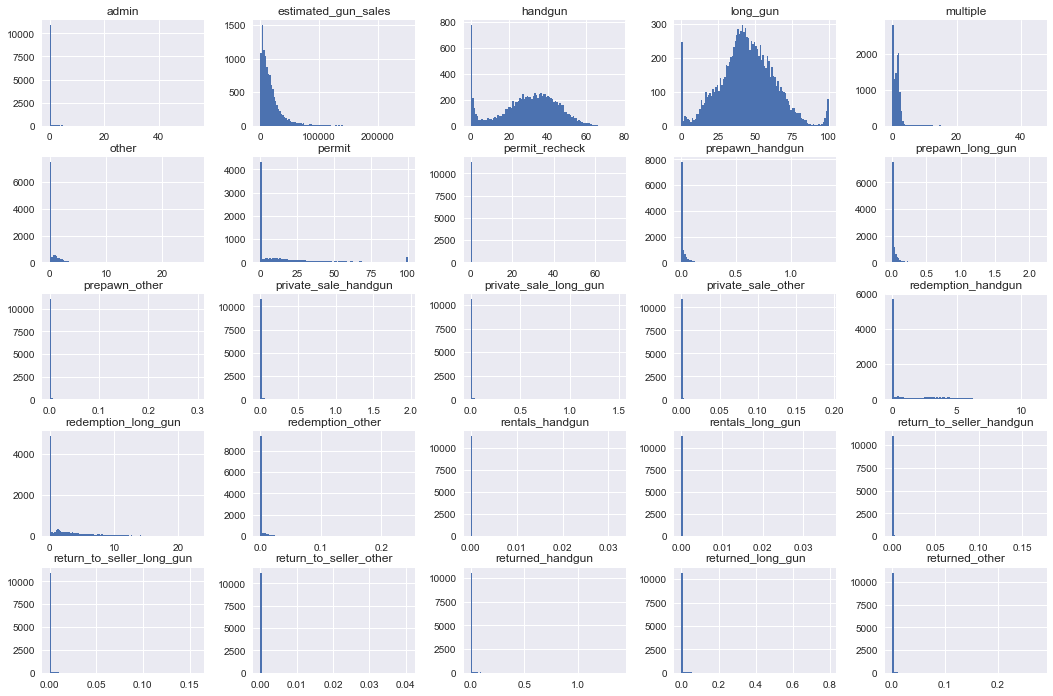

In [511]:
ax=gun_data_n_df.hist(figsize=(18,12),bins=100)

> The decision is to discard any categorie with a maximum value below 5% of totals:
- their contribution is very low
- the shape of the distribution is very narrow around 0

Corresponding categories are allocated either to 'handgun, 'long_gun' or 'other' categories before deleting the column.

<B>After persuing the analysis, I came back to this decision which might look questionnable for private sales. As a few states mandate NICS background checks for private sale, it could have been interesting to keep this categorie as it allows to identify states with this specific gun law.</B> However after preliminary analysis, correlation with gun states laws is not working (see https://consumer.findlaw.com/consumer-transactions/private-gun-sale-laws-by-state.html) As we can see below:
- some states which require checks for private sales have zero records because check is done on behalf by licensed sellers 
- whereas some states who don't require nay check have some records.
- the volume of records is really negligible
- nonetheless, it seems to be working for NY and Washington

<B>Anyhow the initial decision to discard this category is unchanged.</B>

In [512]:
tmp=gun_data_df.groupby('state').mean()
tmp['private_sale_long_gun']+tmp['private_sale_handgun']

state
Alabama            1.90
Alaska             1.94
Arizona            2.15
Arkansas           1.82
California         0.00
Colorado           0.00
Connecticut        0.30
Delaware           8.61
Florida            3.73
Georgia            2.04
Hawaii             0.00
Idaho              1.23
Illinois           0.00
Indiana            6.07
Iowa               0.43
Kansas             1.38
Kentucky           2.70
Louisiana          2.56
Maine              0.75
Maryland           2.63
Massachusetts      8.95
Michigan           1.91
Minnesota          2.60
Mississippi        1.28
Missouri           8.72
Montana            0.93
Nebraska           0.27
Nevada             0.00
New Hampshire      0.86
New Jersey         0.00
New Mexico         0.80
New York          91.89
North Carolina     2.76
North Dakota       1.29
Ohio               4.56
Oklahoma           6.00
Oregon             0.00
Pennsylvania       0.00
Rhode Island       1.74
South Carolina     1.48
South Dakota       0.94
Tennessee 

In [513]:
cols=max_per_categorie[max_per_categorie['max value']<5].index.values
for col in cols:
    if col.find('handgun')>=0:
            gun_data_df['handgun']=gun_data_df['handgun']+gun_data_df[col]
    if col.find('long_gun')>=0:
            gun_data_df['long_gun']=gun_data_df['long_gun']+gun_data_df[col]
    if col.find('other')>=0:
            gun_data_df['long_gun']=gun_data_df['long_gun']+gun_data_df[col]
    print(col, ' (re)allocated!')

gun_data_df=gun_data_df.drop(cols,axis=1)
print('Remaining columns:')
gun_data_df.columns

(u'prepawn_handgun', ' (re)allocated!')
(u'prepawn_long_gun', ' (re)allocated!')
(u'prepawn_other', ' (re)allocated!')
(u'redemption_other', ' (re)allocated!')
(u'returned_handgun', ' (re)allocated!')
(u'returned_long_gun', ' (re)allocated!')
(u'returned_other', ' (re)allocated!')
(u'rentals_handgun', ' (re)allocated!')
(u'rentals_long_gun', ' (re)allocated!')
(u'private_sale_handgun', ' (re)allocated!')
(u'private_sale_long_gun', ' (re)allocated!')
(u'private_sale_other', ' (re)allocated!')
(u'return_to_seller_handgun', ' (re)allocated!')
(u'return_to_seller_long_gun', ' (re)allocated!')
(u'return_to_seller_other', ' (re)allocated!')
Remaining columns:


Index([              u'state',              u'permit',      u'permit_recheck',
                   u'handgun',            u'long_gun',               u'other',
                  u'multiple',               u'admin',  u'redemption_handgun',
       u'redemption_long_gun',              u'totals', u'estimated_gun_sales'],
      dtype='object')

> For remaing categories with low contribution, a closer look to the time-series is necessary
> To do this exploration, we'll use below function

In [514]:
# Plot time serie of a given category for all states ranked per max of records in the category

def plot_checks_ranked(gun_data_df,                      # gun dataframe
                       start=0,end=10,                   # start and end ranks to be plotted
                       ranked_per='permit',              # category to be plotted
                       normalize=False,                  # if True, category is nomalized to totals         
                       start_date='1900-01',             # any index before start_date will be excludd
                       figsize=(18,3),with_legend=True): # figsize & plot legend or not (if False)
    
    df = gun_data_df.copy()
    
    # normalise
    if normalize:
        df.iloc[:,1:-2]=df.iloc[:,1:-2].div(df.loc[:,'totals'],axis=0)*100
    
    # filter per date    
    df=df[df.index>=pd.to_datetime(start_date,format="%Y-%m")]
        
    # Rank states for category
     
    # Filter 
    columns = ['state',ranked_per] 
    ranked=(df[columns].groupby('state').max()).sort_values(ranked_per,ascending=False)

    # plot n first states
    states=ranked[start-1:end].index
    out_df=pd.DataFrame()
    for state in states:
        out_df=pd.concat([out_df,df[df.state==state][[ranked_per]]],axis=1)
        out_df=out_df.rename(columns={ranked_per:str(state)})
    
    ax=out_df.plot(figsize=figsize,legend=with_legend)
    ax.set_title(ranked_per)
    if normalize:
        ax.set_ylabel('% of '+str(ranked_per))
    else: 
        ax.set_ylabel('number of '+str(ranked_per))
    return ax

#### permit_recheck

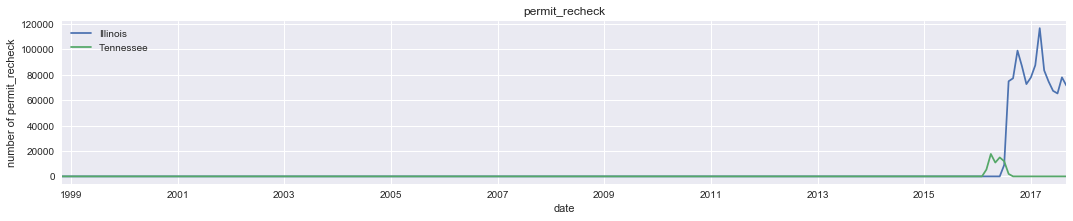

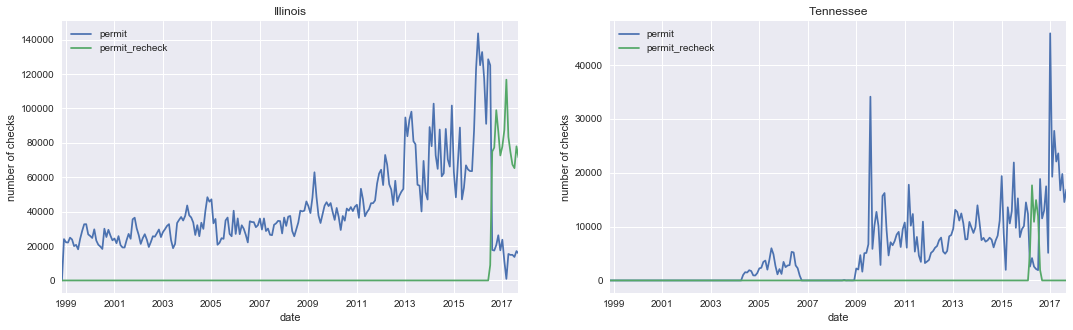

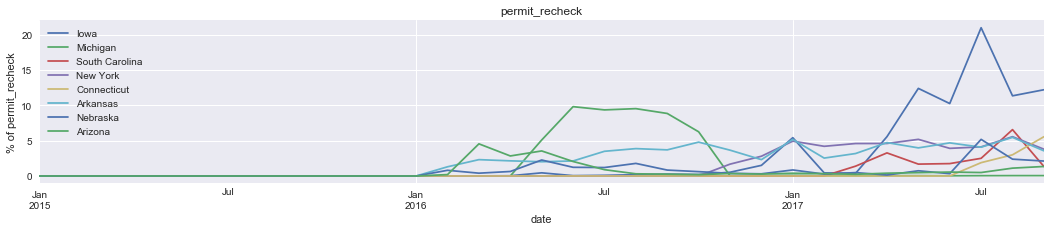

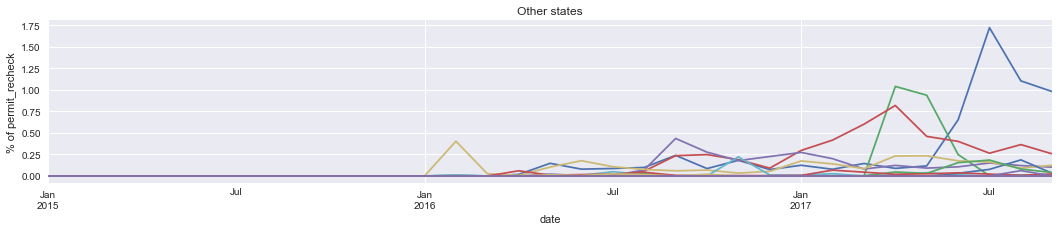

In [515]:
plot_checks_ranked(gun_data_df,start=1,end=2,ranked_per='permit_recheck',figsize=(18,3),with_legend=True)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,5)
ax=(gun_data_df[['permit','permit_recheck']][gun_data_df.state=='Illinois']).plot(ax=axes[0])
ax.set_title('Illinois')
ax.set_ylabel('number of checks')
ax=(gun_data_df[['permit','permit_recheck']][gun_data_df.state=='Tennessee']).plot(ax=axes[1])
ax.set_title('Tennessee')
ax.set_ylabel('number of checks')

ax=plot_checks_ranked(gun_data_df,start=3,end=10,ranked_per='permit_recheck',start_date='2015-01',normalize=True)
ax=plot_checks_ranked(gun_data_df,start=11,end=50,ranked_per='permit_recheck',start_date='2015-01',normalize=True,with_legend=False)
ax.set_title('Other states')

#### permit_recheck

> - for first two states 'Illinois' and 'Tennesee' with signifant records(see above), permit / permit_recheck varies inversely
> - for all others states:
     - this category is only used since 2016 
     - time-series doesn't look very consistent but volume remains low

- Decision is to add these records to 'permit' category and to delete this column

In [516]:
gun_data_df['permit']=gun_data_df['permit']+gun_data_df['permit_recheck']
gun_data_df=gun_data_df.drop('permit_recheck',axis=1)

#### multiple

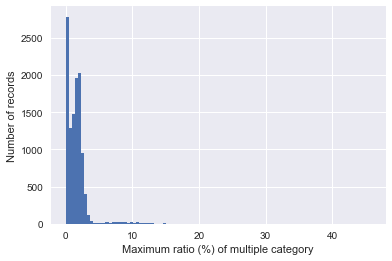

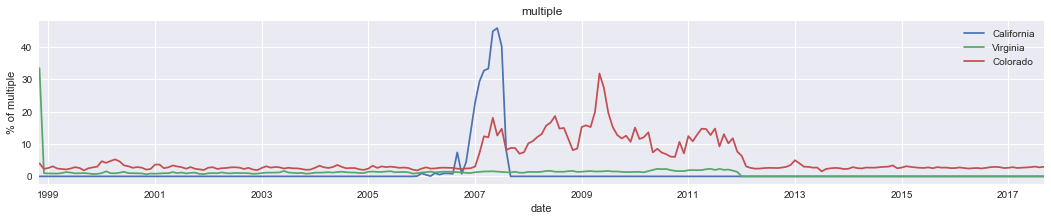

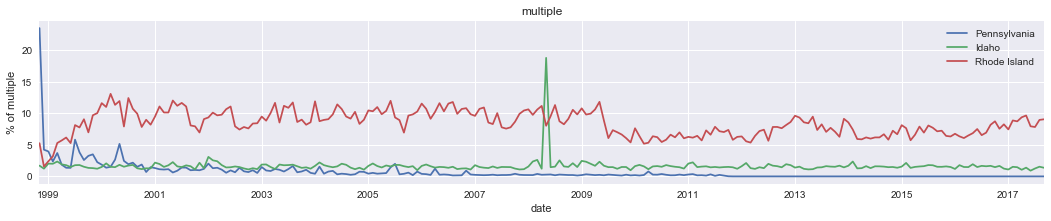

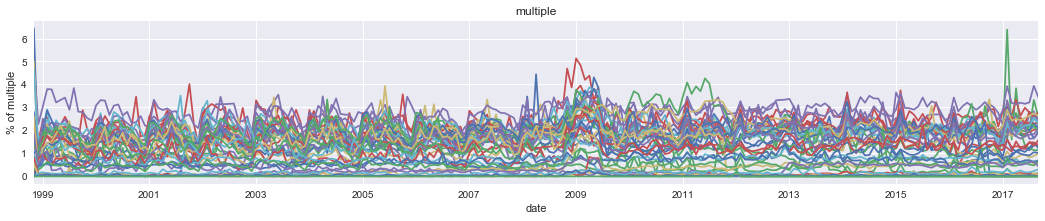

In [517]:
plt.figure()
gun_data_n_df['multiple'].hist(bins=100)
plt.xlabel('Maximum ratio (%) of multiple category')
plt.ylabel('Number of records')
plot_checks_ranked(gun_data_df,start=1,end=3,ranked_per='multiple',normalize=True,figsize=(18,3),with_legend=True)
plot_checks_ranked(gun_data_df,start=4,end=6,ranked_per='multiple',normalize=True,figsize=(18,3),with_legend=True)
ax=plot_checks_ranked(gun_data_df,start=7,end=50,ranked_per='multiple',normalize=True,figsize=(18,3),with_legend=False)

> 
- for California, records for 'multiple' category really looks like outliers. Volume raises from 0 up to 40% of all NICS checks early 2007 and drops down to zero afterwards
- for Virgina, Colorado, Pensylvannia, Idaho, shape of the serie is a bit chaotic as well
- Rhode island has a ratio above others states ~10% but the time serie looks consistent 
- Others states looks consistent

*** For sake of consistency between states and to focus on most important categories, this column is discarded ***

In [518]:
gun_data_df=gun_data_df.drop('multiple',axis=1)

#### other

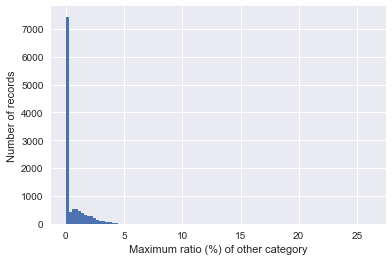

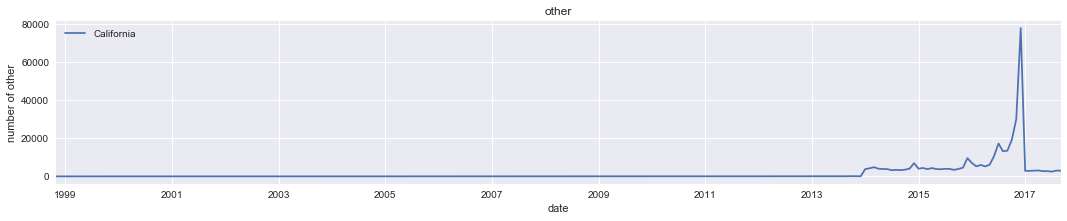

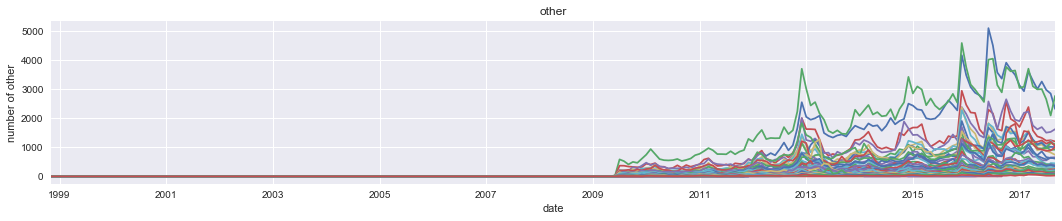

In [519]:
category='other'
gun_data_n_df[category].hist(bins=100,)
plt.xlabel('Maximum ratio (%) of other category')
plt.ylabel('Number of records')
plot_checks_ranked(gun_data_df,start=1,end=1,ranked_per=category,figsize=(18,3),with_legend=True)
plot_checks_ranked(gun_data_df,start=2,end=46,ranked_per=category,figsize=(18,3),with_legend=False)
#ax=plot_checks_ranked(gun_data_df,start=47,end=50,ranked_per=category,figsize=(18,3),with_legend=True)

> 
- this category is ony used since  mid 2009
- California time-serie looks as an outlier 
- Other states are fairly consistent

*** For sake of consistency, this column is discarded ***

In [520]:
gun_data_df=gun_data_df.drop('other',axis=1)

#### admin
- This category is clearly chaotic and not consistent between states

*** Decision is to discard this column ***

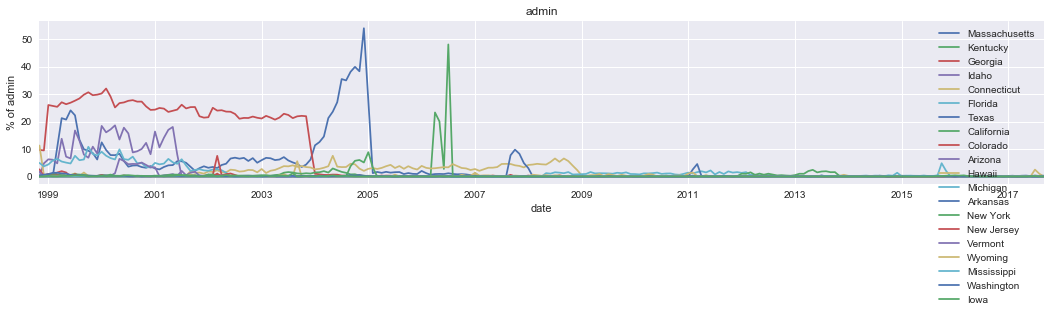

In [521]:
plot_checks_ranked(gun_data_df,start=1,end=20,ranked_per='admin',figsize=(18,3),normalize=True,with_legend=True)

In [522]:
gun_data_df=gun_data_df.drop('admin',axis=1)

#### redemption_*

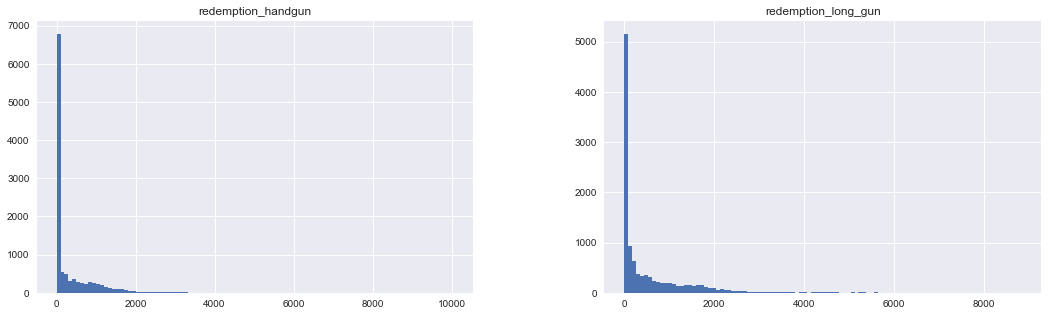

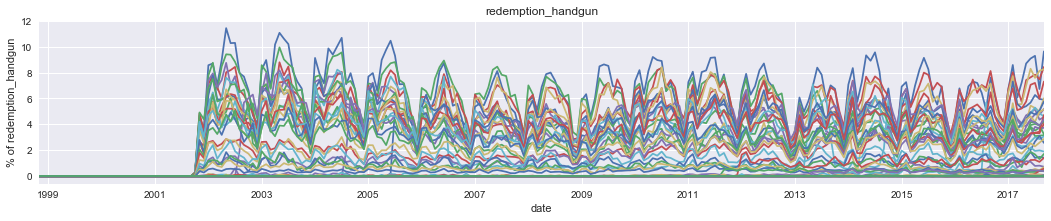

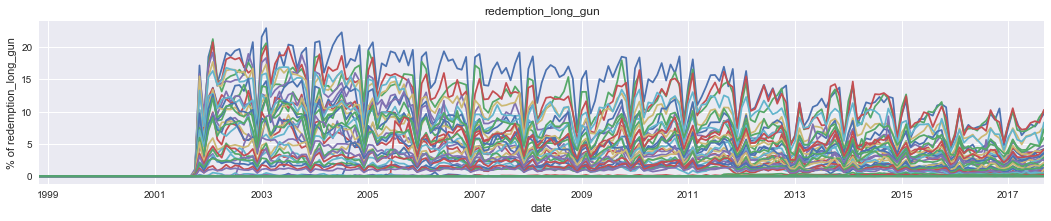

In [523]:
gun_data_df[['redemption_handgun','redemption_long_gun']].hist(figsize=(18,5),bins=100)
plot_checks_ranked(gun_data_df,start=1,end=50,ranked_per='redemption_handgun',figsize=(18,3),normalize=True,with_legend=False)
plot_checks_ranked(gun_data_df,start=1,end=50,ranked_per='redemption_long_gun',figsize=(18,3),normalize=True,with_legend=False)

> - These two categories are fairly consistent

*** As their contribution is significant, records are added to handung/long_gun categories and columns are deleted ***

In [524]:
gun_data_df['handgun']=gun_data_df['handgun']+gun_data_df['redemption_handgun']
gun_data_df['long_gun']=gun_data_df['long_gun']+gun_data_df['redemption_long_gun']
gun_data_df=gun_data_df.drop(['redemption_handgun','redemption_long_gun'],axis=1)

In [525]:
# after this cleaning, new totals need to be re-calculated,
gun_data_df['totals']=gun_data_df.iloc[:,1:4].sum(axis=1)
# print final dataset
gun_data_df.head(5)

state  permit  handgun  long_gun  totals  \
date                                                           
1998-11-30        Wyoming       8       45        49     102   
1998-11-30  Massachusetts       0        4        39      43   
1998-11-30       Maryland      59       82       177     318   
1998-11-30          Maine       0       54        41      95   
1998-11-30      Louisiana       0      322       471     793   

            estimated_gun_sales  
date                             
1998-11-30               113.40  
1998-11-30                47.30  
1998-11-30               284.90  
1998-11-30               114.50  
1998-11-30               884.30

<a id='eda'></a>
## Exploratory Data Analysis

<a id='Q1'></a>
### Q1: NICS checks at US level
- To perform this exploration, the function below allows to plot time serie of gun_data_df (US or state level) with some options on a moving average

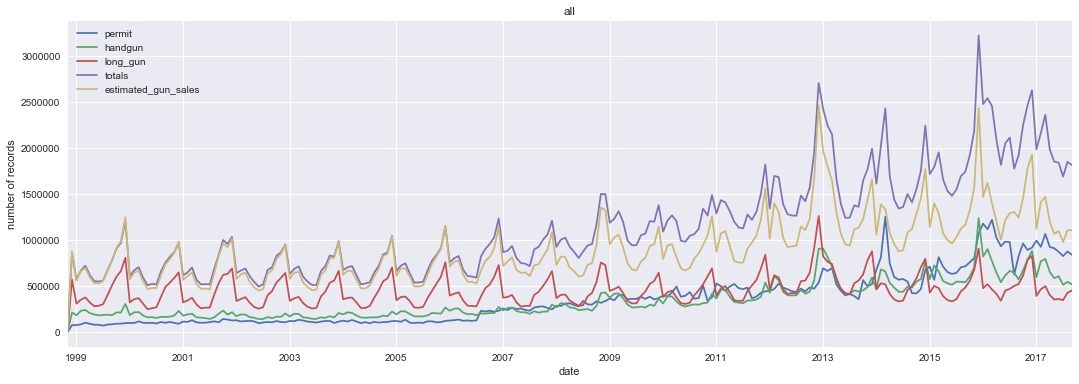

In [526]:
def plot_gun_data_serie(gun_data_df,state='all',smooth=False,av_period=12,figsize=(18,6)):
    
    # US level
    if state=='all':
        gun_data_df = gun_data_df.reset_index()
        gun_data_df = gun_data_df.groupby('date').sum()
    else:
        # filter for one state
        gun_data_df = gun_data_df[gun_data_df.state==state]
    
    # moving average on av_period
    if smooth==True:
        gun_data_df = gun_data_df.rolling(av_period,center=True).mean()
    
    # plot
    ax=gun_data_df.plot(figsize=figsize)
    ax.set_title(state)
    plt.ylabel('number of records')
    return ax
    
plot_gun_data_serie(gun_data_df)

- trend is globally positive for all categories and seems to be more accentuated since 2007
- seasonal variation is obvious with a raise by the end of the year
- gap between estimated gun sales (as proposed per NY times) and totals NICS checks tends to increase with time
- long_gun checks are below hand_gun checks since 2015
- trend seems steady or even decreasing last two years

###### > analyse seasonal variation
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

> Basic assumption to be checked: a moving 12 months average makes the job

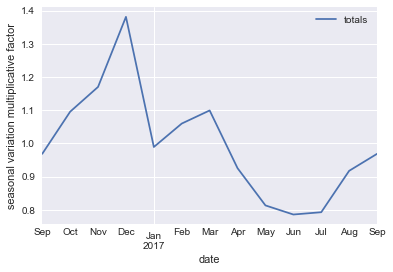

In [527]:
from statsmodels.tsa.seasonal import seasonal_decompose
copy_gun_data_df=gun_data_df.copy()
copy_gun_data_df=copy_gun_data_df.reset_index()
result = seasonal_decompose(copy_gun_data_df[['date','totals']].groupby('date').sum(), model='multiplicative', freq=12)
s=result.seasonal
trend=result.trend
s[-13:].plot()
plt.ylabel('seasonal variation multiplicative factor')

- raise takes place by the end of the year (up to 40% in Dec) 
- there is a drop early summer (up to -20%), it might be linked to hunting season?

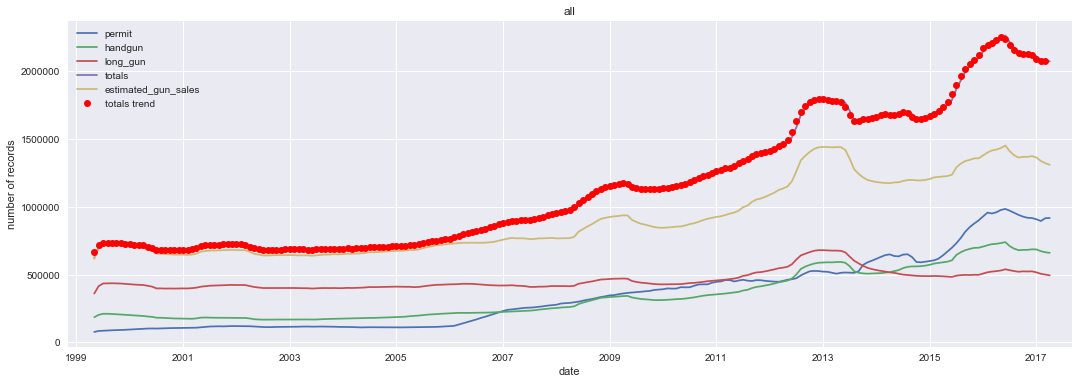

In [528]:
ax=plot_gun_data_serie(gun_data_df,smooth=True,av_period=12)
fig=ax.get_figure()
# cross-check that 12 months moving average fits seasonal trend identified per statsmodels.tsa
ax=trend.plot(ax=ax,style='ro')

handles,labels = ax.get_legend_handles_labels()
labels[5]='totals trend'
ax.legend(handles, labels)

- once seasonal variations are removed, initial observations are confirmed and more conclusive:
    - global trend for totals is steeper since 2006
    - handgun checks overcome long_gun checks since 2014
- some peaks can be observed (9/2001, 2009, 2013, 2016), some interpretations are provided in the article of NY times https://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html (9/11, Obama election and re-election related to anticipation of more restrictive gun laws)

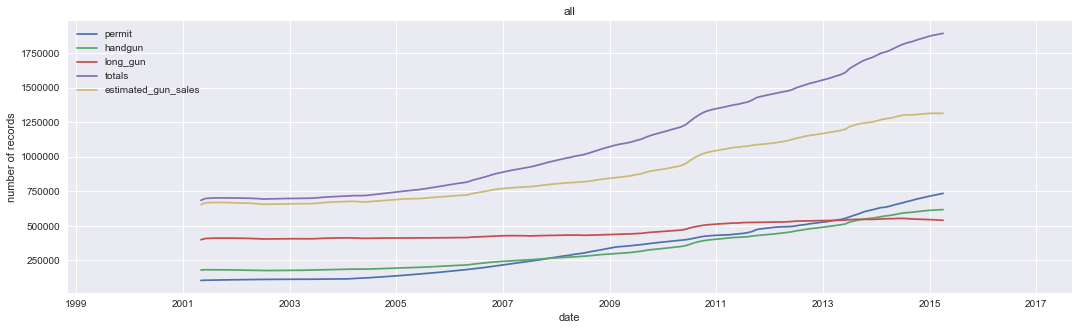

In [529]:
ax=plot_gun_data_serie(gun_data_df,state='all',smooth=True,av_period=60, figsize=(18,5))

- if you smooth time-series over 5 years, trends are more obvious per categories:
    - long gun is quite stable since the very begining but tends to decrease
    - hand gun overrides long guns since a couple of years 
    - permit increase is almost geometric, so is the gap between estimated gun sales and permit

<a id='Q2'></a>
### Q2: NICS checks at state level


- Rank states per category of NICS check, are ranking consistent?
- Can we correlate -a priori- to US demography?

In [530]:
gun_data_df.groupby('state').max().sort_values('estimated_gun_sales',ascending=False)[0:5]

permit  handgun  long_gun  totals  estimated_gun_sales
state                                                               
Texas          56900   113976    113891  232701            250999.80
California    134211    74979     94134  243363            174179.50
Florida        34627    89709     60817  161680            156307.40
Pennsylvania   44433    90457    105826  153769            120269.60
Ohio           19568    61729     48280  114862            115250.80

If we sort top 5 states by 'estimated_gun_sales', we pop out 5 of the most populated states of US even if NY and Illinois are missing (https://en.wikipedia.org/wiki/Demography_of_the_United_States)

Below function:
- ranks states for a given category of checks
- Barplot the result including all categories.
- plot Q3+1.5*IQ to identify outliers candidates.

##### States ranked per 'permit' category

In [531]:
def plot_ranked_categorie(gun_data_df,n=10,
                          category='totals',
                          asc_order=False,
                          start_date='1900-01',end_date='2099-01',
                          figsize=(15,3)):
    df=gun_data_df.copy()
    # filter between start_date and end_date
    df=df[(df.index>=pd.to_datetime(start_date,format="%Y-%m"))&(df.index<=pd.to_datetime(end_date,format="%Y-%m"))]

    # group by state and calculate mean over the period
    mean_df=df.groupby('state').mean()
    mean_df=mean_df.sort_values(category,ascending=asc_order)
    plt.figure()
    ax =mean_df[0:n][['permit','handgun','long_gun']].plot(kind='bar',figsize=figsize)
    handles, labels = ax.get_legend_handles_labels()

    q=mean_df[category].quantile([0.25,0.75])
    iq=q.iloc[1]-q.iloc[0]
    
    if not(asc_order):
        plt.title('Top ' + str(n) + ' states sorted by ' + category)
        # Q3+1.5*IQ line
        qm=q.iloc[1]+1.5*iq 
        ax=plt.axhline(qm,color='red')
        handles += [ax]
        labels += ['Q3+1.5*IQ limit (' +str(category)+')']
    else:
        ax=plt.title('Bottom ' + str(n) + ' states sorted by ' + category)
   
    plt.legend(handles,labels)
    plt.ylabel('number of checks')

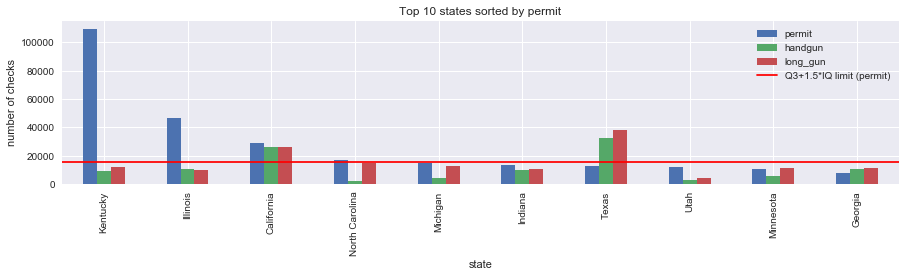

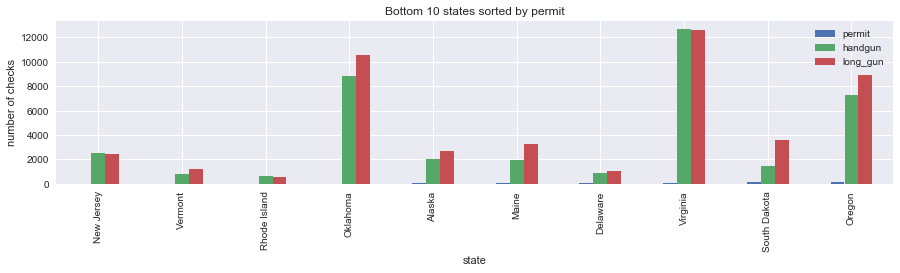

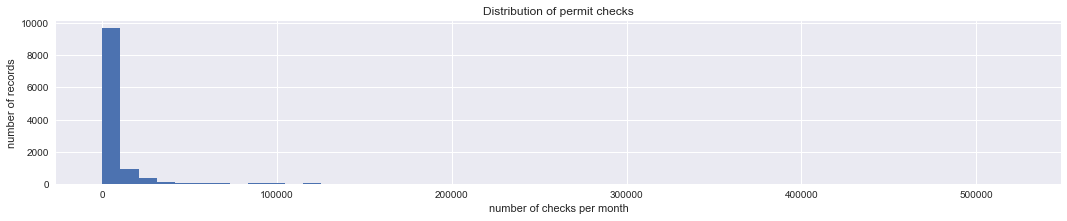

In [532]:
ax=plot_ranked_categorie(gun_data_df,category='permit')
ax=plot_ranked_categorie(gun_data_df,category='permit',asc_order=True)
plt.figure(figsize=(18,3))
gun_data_df.permit.hist(bins=50)
plt.ylabel('number of records')
plt.xlabel('number of checks per month')
plt.title('Distribution of permit checks')

- Kentucky and Illinois should be outliers for permit category
- Many states has no or few permit checks

##### States ranked per 'handgun' category

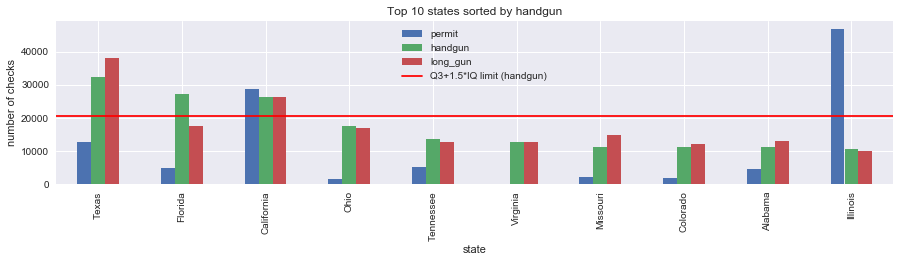

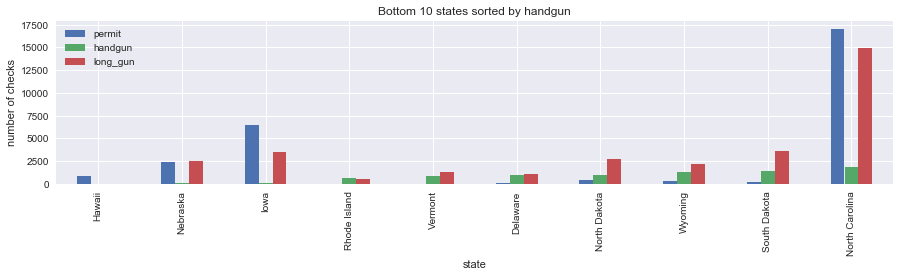

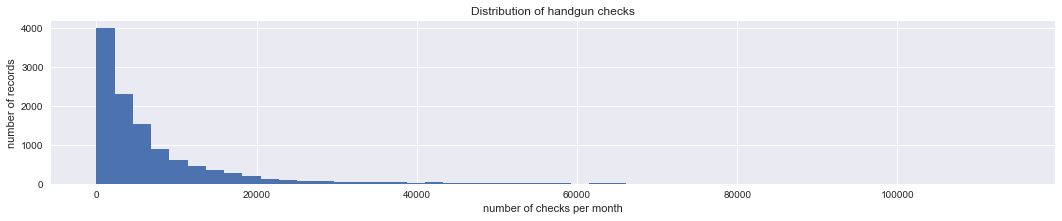

In [533]:
ax=plot_ranked_categorie(gun_data_df,category='handgun')
ax=plot_ranked_categorie(gun_data_df,category='handgun',asc_order=True)
plt.figure(figsize=(18,3))
gun_data_df.handgun.hist(bins=50)
plt.ylabel('number of records')
plt.xlabel('number of checks per month')
plt.title('Distribution of handgun checks')

- Top three states are consistent with demography and should'nt be considered as outliers
- There are many states with no or few records.

##### States ranked per 'long_gun' category

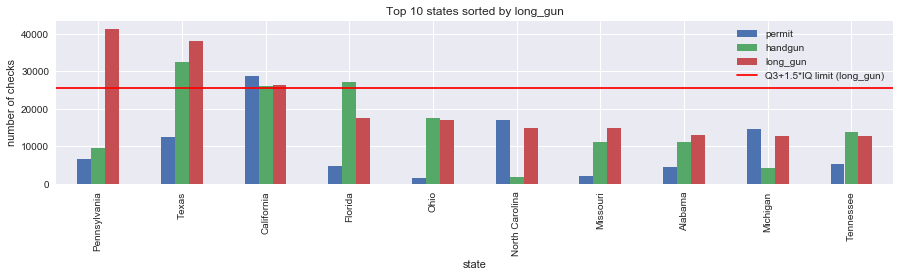

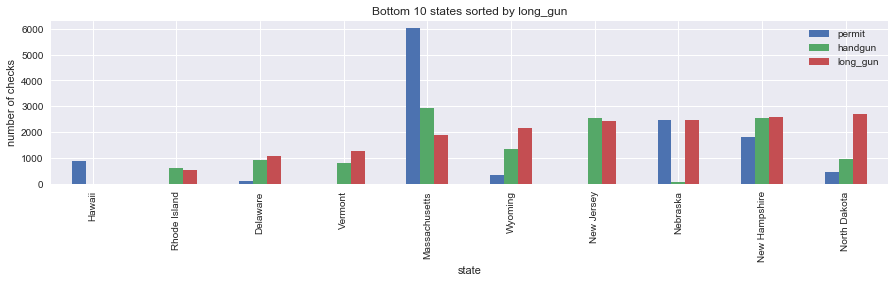

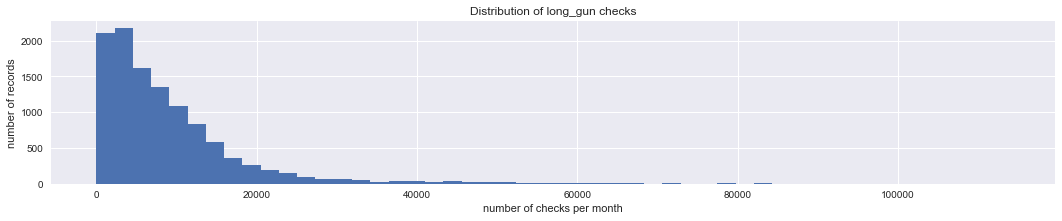

In [534]:
ax=plot_ranked_categorie(gun_data_df,category='long_gun')
ax=plot_ranked_categorie(gun_data_df,category='long_gun',asc_order=True)
plt.figure(figsize=(18,3))
gun_data_df.long_gun.hist(bins=50)
gun_data_df.long_gun.describe()
plt.ylabel('number of records')
plt.xlabel('number of checks per month')
plt.title('Distribution of long_gun checks')

- Pennsylvania looks like an outlier
- Other top states are consistent with demography and should'nt be considered as outliers
- All bottom states have a signifcant number of records apart Hawaii which has no records. Actualy, this state has only 'permit' records.

##### Partial conclusion
- Following states are likely following an outlier pattern for 'permit' category: Kentucky, Illinois and maybe North Carolina (volume above Q3+1.5IQ and not top populated states)
- Many states have no or few 'permit' records, this should be considered as a 'particular' pattern as the number of states whith similar pattern are numerous. Some more analysis are required to find out where this is coming from (see next section)
- Many states have no or few 'handgun' records', this should be considered as a particular pattern and more investigations are required as well. 
- 'long_gun' seems to be the category presententing the most consistent distribution: only  Pennsylvania (top) and Hawaii (no records) looks like outliers, and the standard deviation is the lowest.
- Hawaii seems to be a particular case as this state only peform 'permit' checks

<a id='Q3'></a>
### Q3:  Identify patterns in checks categories

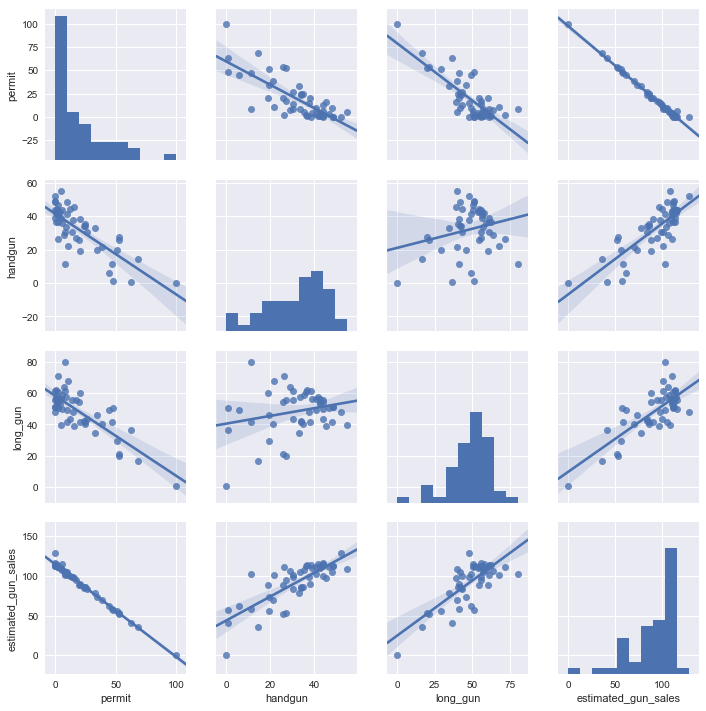

In [535]:
df = gun_data_df.copy()
df.iloc[:,1:]=df.iloc[:,1:].div(df.loc[:,'totals'],axis=0)*100
mean_per_state=df.groupby('state').mean()
sns.pairplot(mean_per_state[['permit','handgun','long_gun','estimated_gun_sales']],kind='reg')

- Strong negative correlations can be observed between 'permit' category and all others categories. The correlation between 'estimated_gun_sales' (which is roughly the sum of hangun and long_gun) and 'permit' categories is particularly striking as dots are almost aligned. Basically there are less 'estimated_gun_sales' when more 'permit' checks are performed. 
- As detailed by the FBI document, a firearm permits to carry allows to purchase firearm without any background check <I>"A NICS check is not required if a transferee presents a valid Permit to Carry issued through the state POC that the ATF has indicated satisfies the provisions for the permit exception included in the Brady Act."</I>. So the most likley asummption is that the check is performed at permit delivery instead of sale. This would explain this negative correlation.
- Conversely, we can conclude that the estimator of gun sales proposed by NY times is not really accurate for states which perform background checks on permit delivery only.


To attempt to identify patterns, we'll study the scattering of the different NICS checks categories per states. This is the purpose of the block of code in the cell below. Main function 'plot_scatter_map_us' plots a scatter map (hangun/longun/permits) ratios for each states.

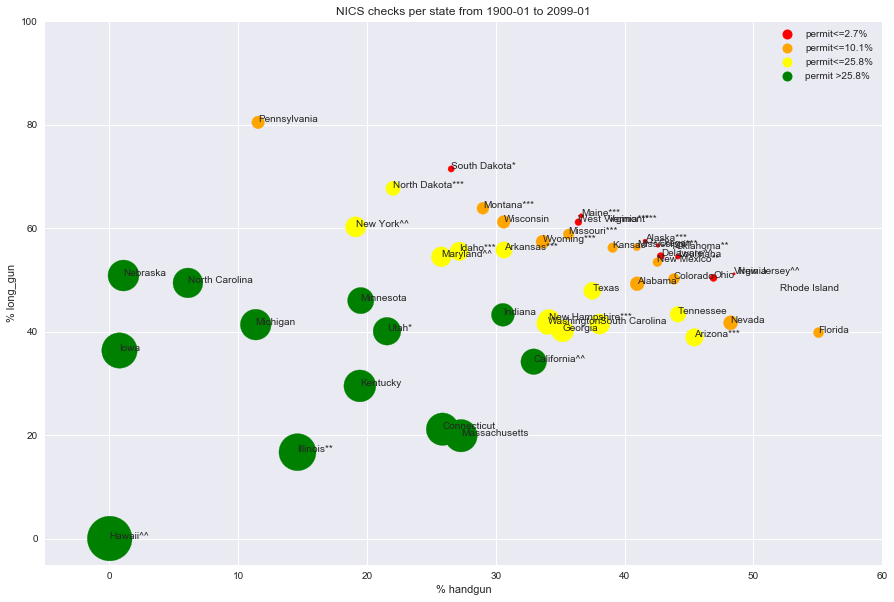

In [536]:
def annotate_state_dot(df,state_is_index=True):
    
    if state_is_index:
        states=df.index
    else:
        states=df.state
        
    for state, x, y in zip(states,df.handgun,df.long_gun):
        # https://en.wikipedia.org/wiki/Concealed_carry_in_the_United_States
        # State unrestricted  add '***'
        if state in ['Alaska','Arkansas','Arizona','Idaho','Kansas','Maine',
                     'Mississippi','Missouri','Montana','New Hampshire',
                     'North Dakota','Vermont','West Virginia','Wyoming']:
            state = state + '***'
        # limited form of permitless concealed carry 
        if state in ['Illinois','Montana','New Mexico','Oklahoma']:
            state = state + '**'
        # U.S. states that have passed constitutional carry bills subsequently vetoed by the governor 3.1 Oklahoma
        if state in ['South Dakota','Utah']:
            state = state + '*'
        # May issue states, add '^^^'
        if state in ['California','Connectitut','Delaware','Hawaii','Maryland','Massachusets','New Jersey','New York']:
            state = state + '^^'            
        plt.annotate(state,xy=(x,y))
        
# return color of dot depending on interquartiles defined per r [25%,50%,75%] 
def color(x,r):
    if x<=r[0]:
        c='red'
    elif x<=r[1]:
        c='orange'
    elif x<=r[2]:
        c='yellow'
    else:
        c='green'       
    return c  
    
# Main function
def plot_scatter_map_us(gun_data_df, 
                        normalize=True,
                        start_date='1900-01',end_date='2099-01',
                        figsize=(15,10),xlim=60,ylim=100):
    # copy (still don't master mutable objects ... tbc)
    df = gun_data_df.copy()
    # normalize 
    if normalize:
        df.iloc[:,1:-2]=df.iloc[:,1:-2].div(df.loc[:,'totals'],axis=0)*100
    # filter per date
    df=df[(df.index>=pd.to_datetime(start_date,format="%Y-%m"))&(df.index<=pd.to_datetime(end_date,format="%Y-%m"))]
    # calculate mean of categories per states on the period
    mean_per_state=df.groupby('state').mean()
    # interquartiles of permit category on the period
    r = mean_per_state.permit.quantile([0.25,0.5,0.75]).values
    # get corresponding colors
    colors = mean_per_state.permit.apply(color,args=(r,))
    
    plt.figure(figsize=figsize)
    # plot scatter for all states
    ax= plt.scatter(mean_per_state.handgun,mean_per_state.long_gun,s=mean_per_state.permit*20,c=colors)
    
    # annotate by state name
    annotate_state_dot(mean_per_state)
    
    plt.xlabel('% handgun')
    plt.ylabel('% long_gun')
    plt.xlim((-5,xlim))
    plt.ylim((-5,ylim))
    plt.title('NICS checks per state from '+str(start_date)+' to '+str(end_date))
    plt.grid(b='on')

    #https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
    colors = ["red","orange","yellow","green"]
    
    def get_label_r(r):
        return "permit<="+str(format(r,'1.1f'))+"%"
    get_label_r = np.vectorize(get_label_r)
    texts = get_label_r(r)
    texts = list(texts) + ["permit >"+str(format(r[2],'1.1f'))+"%"]
    patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches)


    
r= plot_scatter_map_us(gun_data_df)



This scatter plot depicts the ratio between handgun, long_gun and permits background checks categories for all US states averaged on the whole period:
- x axis is % of hangun checks
- y axis is % of long_gun checks
- the color of each circle corresponds to different interquartile of permit checks:
    - red <= 25%
    - orange ]25%,50%]
    - yellow ]50%,75%]
    - green > 75%
    - values of 'permit' checks interquarlite are indicated in the title
- the size of a circle if proportional to % of 'permit' checks. Empty circles  have no 'permit' checks.

##### Partial observation / conclusion
Some trends can be observed:
- As noticed in the first scatter matrix, permit checks are inversely correlated to handgun and long_gun categories. We can see that states requiring more permit checks (green dots) are mainly located in bottom left part of the diagram, whereas those with few permit checks (red or 'null' dots) are on the upper right part.
- Inverse correlation between permit and handguns checks seems stronger as there are many 'green' states in the left part of the diagram

- Based on these observations, we'd tend to identify most permissive states as "red" ones and most restrictive as "green" ones. 
- Identically, states located in the same cluster should share similar gun laws
- Unfortunately, <B>these assumptions doesn't work very accurately because states gun laws are very tricky.</B>

To try to explain these patterns, state gun laws have been studied based on these sources:
https://everytownresearch.org/navigator/index.html
https://en.wikipedia.org/wiki/Gun_laws_in_the_United_States_by_state

Our understanding is that following rules can influence these main NICS checks categories (permit, handgun and long_gun):
- First of all, as explained in the introduction, the federal law, mandated by the Brady Handgun Violence Prevention Act (Brady Law) of 1993 and launched by the Federal Bureau of Investigation (FBI) in 1998 (see https://www.fbi.gov/services/cjis/nics) requires background checks for any sale of firearm by a licensed seller - <B>This rule is the main driver but can be interpretated by the state with some variations</B>:
    - Most states strictly applies the law and background checks are performed by the licensed seller when the firearm sale takes place (handgun or long_gun category)
    - However, some states deliver in lieu a "permit of purchase" either for handgun or/and long_gun with a background check. In such cases, background checks falls into 'permit' category as they are only performed when the purchase permit is delivered. This is the case of Hawaii, this state deliver a permit of purchase for both handgun and long_gun, so any firearm sale falls into 'permit' category. Iowa or Nebraska only requires this purchase permit for 'handgun', this is why this category remains null for these states. <B>For such states, gun sales estimator suggested by NY times doesn't work at all as firearm sales are masked by the 'permit' category.</B>
    - Some other states require a "purchase permit" but will peform an additional background check when the firearm sale takes place. The total ammount of checks will artifically be increased for these states.
    - Some states requires "purchase permits" but don't perform a NICS background check when the permit is delivered. In such cases, the NICS check is mandatory during the firearm sale to comply with federal law.
- States can require a permit in order to carry a concealed handgun in public with or without background check. This concealed carry permit can follow a renewal process with or without background check as well. This permit can also allow to buy a firearm without any background check (comparable to purchase permit)
- States can also require criminal background checks for gun sales by <U>unlicensed</U> sellers (private sales). 

This complexity makes interpretation of clusters potentially misleading. For example this is the case of 'New Jersey'. This state is clustered with permissive states (red dots) but has very restrictive gun laws (refer to https://en.wikipedia.org/wiki/Gun_laws_in_New_Jersey). For instance:
- permits are required for purchase for both handgun and long guns
- concealed carry permits is mandatory for both handgun and long guns 
But none of these permits delivery requires a NICS background check. Basically this state only requires background checks for firearm sales event if it has very restrictive laws.

However clustering works rather well in 'average'. For example all states with 'unrestricted concealed carry' (no permit and thus no check required) are identified in the diagram above with three stars '***' following the state name on the scatter diagram. We can see that all these states are mostly located in the top right part of the diagram.

Another difficulty is that state gun laws evolves along time (politics decision...). This aspect is illustrated below. The same scatter diagram is drawn for different time periods <=2005,[2006-2010],[2011,2015],>=2016:

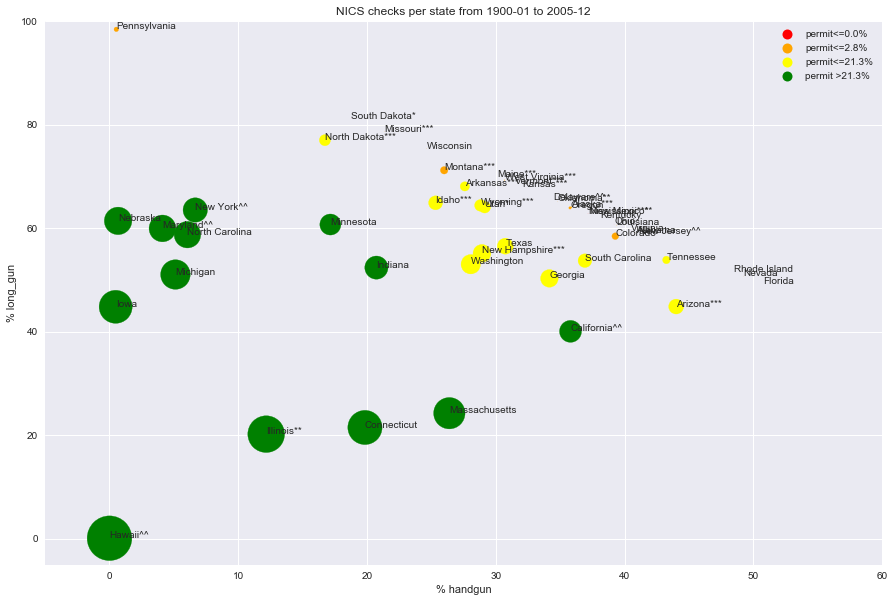

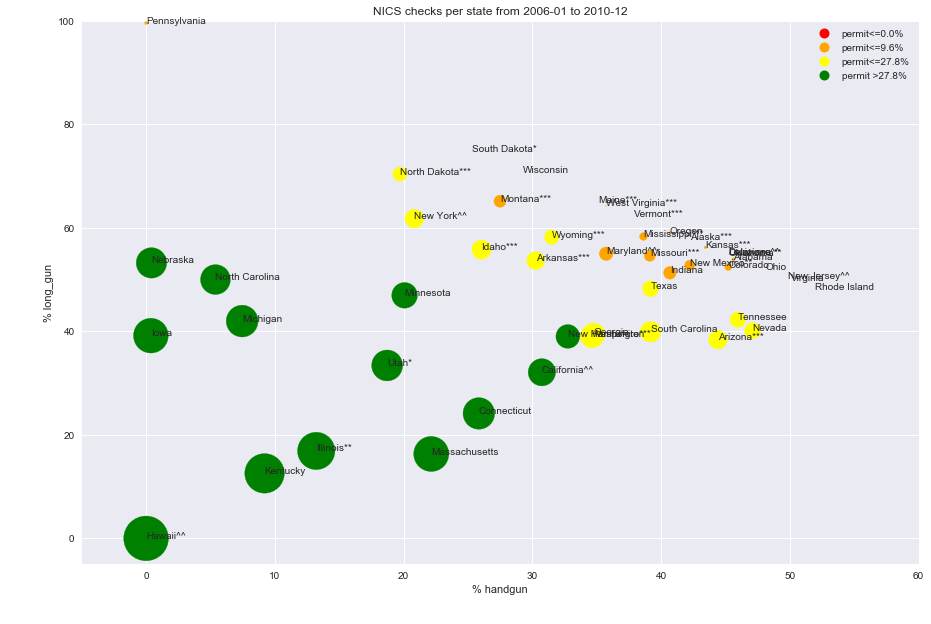

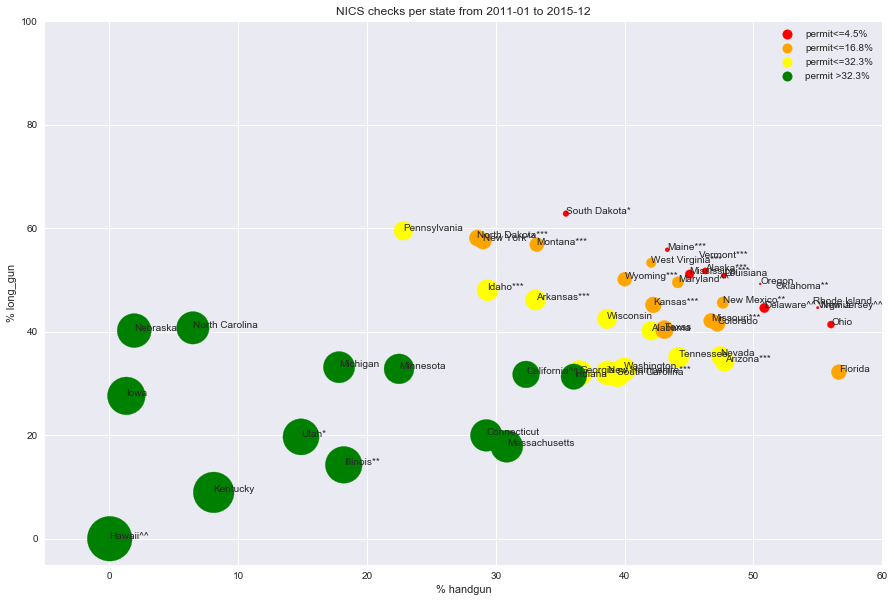

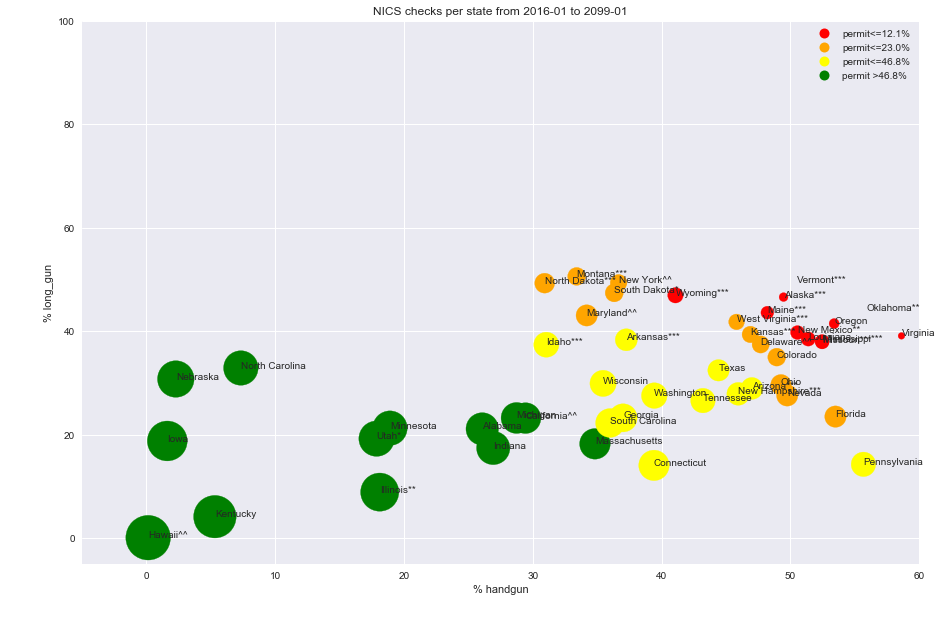

In [537]:
plot_scatter_map_us(gun_data_df,end_date='2005-12')
plot_scatter_map_us(gun_data_df,start_date='2006-01',end_date='2010-12')
plot_scatter_map_us(gun_data_df,start_date='2011-01',end_date='2015-12')
plot_scatter_map_us(gun_data_df,start_date='2016-01')

- A lot of states moves on the diagram along time. Pennsylvannia or Kentucky are good examples (see detailed analysis below).
- At the opposite, Vermont is rather stable even if it progressively slides down to the right (more hand guns / less long guns). 
- Most stable states are "restrictive" green dots states (Iowa or Illinois are picked as examples, see detailed analysis below). These states also seems to be early adopters as the number of permit checks is important since the very begining.
- These diagrams highlights main trends observed on time series at US level: 'handgun' and 'permit' checks categories increases for almost all states along years, whereas 'long_gun' category tends to decrease.
- Another key observation is that the global scattering tends to decrease.

Below function allows to plot the evolution of a state on this scatter diagram by years. Corresponding time-serie is plotted aside. We'll plot this evolution for all states we've already identified with an outlier pattern during the ranking analysis:
- high volume of 'permit': Kentucky, Illinois, North Carolina 
- no 'handgun' records: Hawaii, Nebraska, Iowa
- high volume of 'long_gun': Pensylvania

In [538]:
# plot the evolution for a given state per year (based on the same symbols than previous diagram)
def plot_scatter_map_ev(gun_data_df,
                        normalize=True,
                        state='all',
                        figsize=(16,5)):
    
    df = gun_data_df.copy()
    
    if normalize:
        df.iloc[:,1:-2]=df.iloc[:,1:-2].div(df.loc[:,'totals'],axis=0)*100
    
    df['year']=gun_data_df.index.year
    us_permit_quantiles_per_year=df.groupby('year').permit.quantile([0.25,0.5,0.75]).values
  
    # filter per state
    if state!='all':
        df=df[df.state==state]
        gun_data_df=gun_data_df[gun_data_df.state==state]
    
    mean_per_year=df.groupby('year').mean()
    
    colors = []
    i=0
    for x in mean_per_year.permit:
        colors.append(color(x,us_permit_quantiles_per_year[3*i:3+3*i]))
        i += 1
    
    plt.figure(figsize=figsize)
       
    gs = gridspec.GridSpec(1,2,width_ratios=[1, 2])
    plt.subplot(gs[0])
    plt.scatter(mean_per_year.handgun,mean_per_year.long_gun,s=mean_per_year.permit*50,c=colors)
    plt.grid(b='on')
    for year, x, y in zip(mean_per_year.index,mean_per_year.handgun,mean_per_year.long_gun):         
        plt.annotate(year,xy=(x,y))
    
    plt.xlabel('% handgun')
    plt.ylabel('% long_gun')
    plt.title(state+' NICS checks repartition evolution') 
    
    ax=plt.subplot(gs[1])
    gun_data_df = gun_data_df.rolling(12,center=True).mean()
    gun_data_df.plot(ax=ax)
    plt.ylabel('number of checks')
    plt.grid(b='on')
    plt.title(state+' NICS checks time-series') 

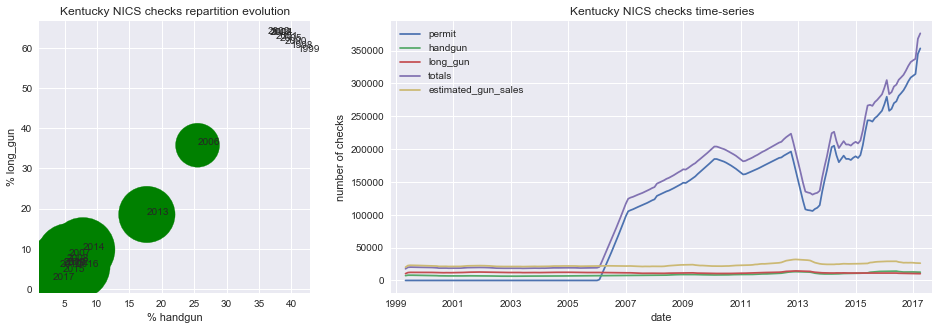

In [539]:
plot_scatter_map_ev(gun_data_df,state='Kentucky')

- Kentucky evolves from a 'no permit' regulation to a massive increase of permit checks from 2006
- The "root cause" is explained in this article (https://wfpl.org/kentucky-background-checks-stand-out/). Actually Kentucky requires automatic monthly background checks on every holder of concealed-carry permits in the commonwealth.
- For sake of comparison with others states this category would need to be corrected for Kentucky

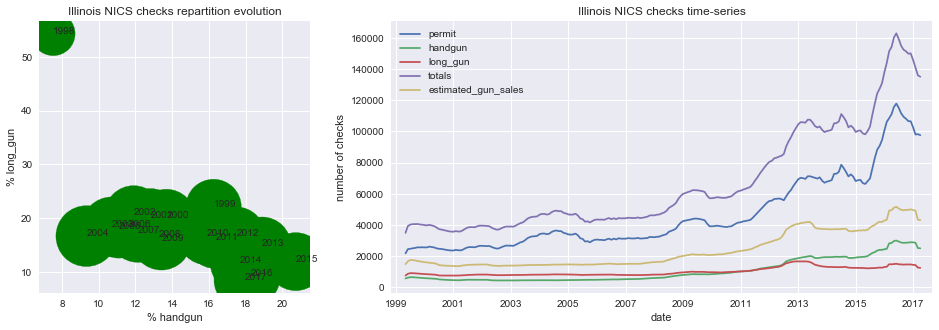

In [540]:
plot_scatter_map_ev(gun_data_df,state='Illinois')

- Illinois 'high permit' pattern is rather stable
- As described above, Illinois is a double check state:
    - when the "permit for purchase" is delivered
    - when the sales take place
- This rule holds both for handgun or long guns.
- In addition, it requires NICS for private sellers
- All these state laws specificities explain why the proportion of 'permit' checks is so important

see https://en.wikipedia.org/wiki/Gun_laws_in_Illinois

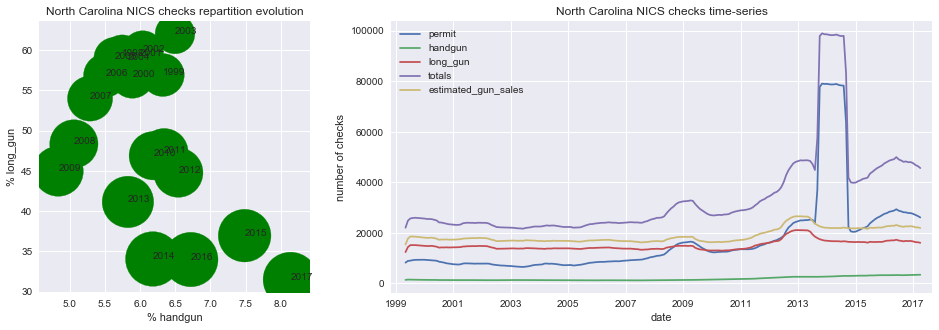

In [541]:
plot_scatter_map_ev(gun_data_df,state='North Carolina')

- There is clearly an abnormal raise of permit checks in 2014 for  North Carolina
- If we put this anomaly aside, this state superseedes background checks for handgun sales by a permit delivery (either purchase or concealed carry)
- Despite this rule, some background checks for handgun sales are still performed. A guess is that some licensed sellers perform these checks on their own initiative.

see https://en.wikipedia.org/wiki/Gun_laws_in_North_Carolina

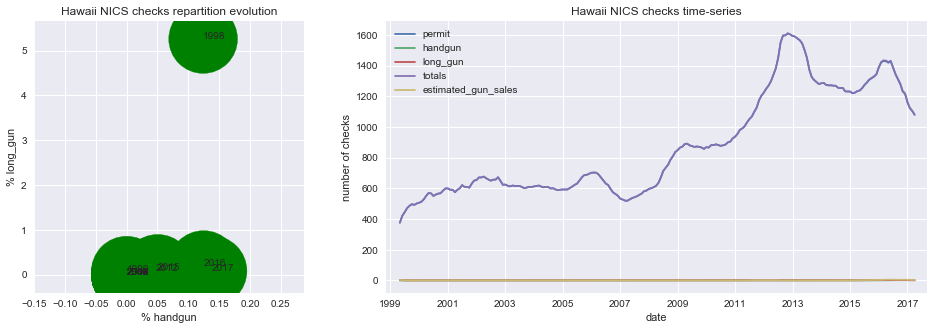

In [542]:
plot_scatter_map_ev(gun_data_df,state='Hawaii')

- Hawaii is the only 'full permit' state

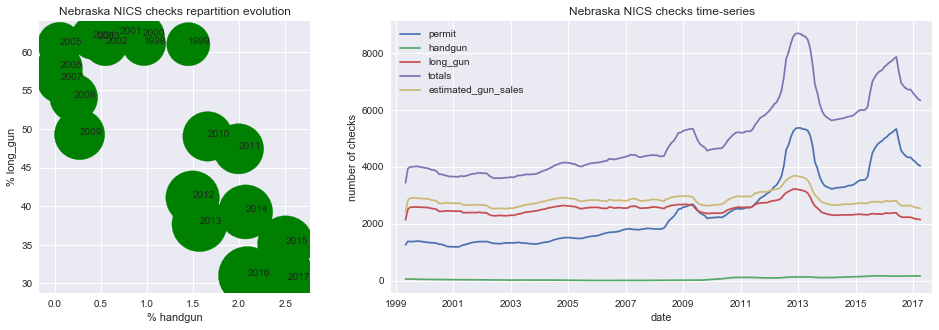

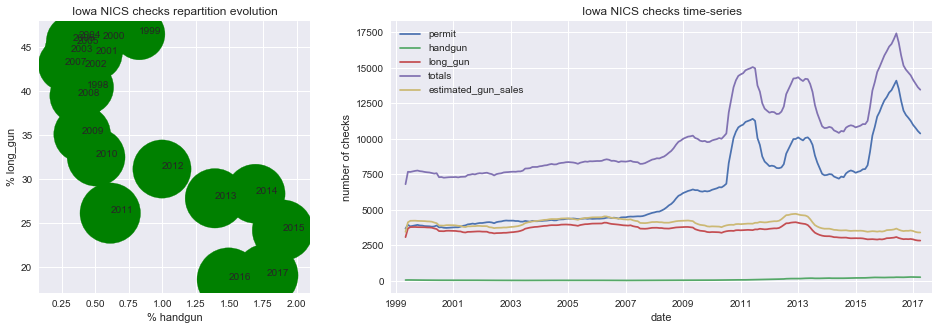

In [543]:
plot_scatter_map_ev(gun_data_df,state='Nebraska')
plot_scatter_map_ev(gun_data_df,state='Iowa')

These two states superseede background checks for handgun sales by a permit delivery (either purchase or concealed carry) - as North Carolina

<a id="pennsylvania"/>
##### Pennsylvania

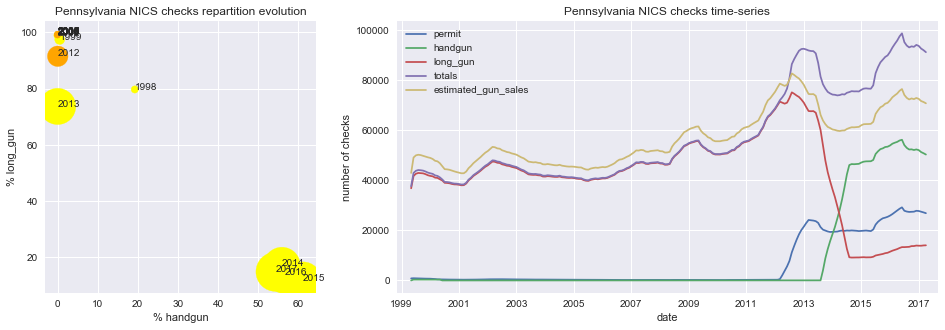

In [544]:
plot_scatter_map_ev(gun_data_df,state='Pennsylvania')

- the pattern of Pennsylvania is a rather diffcult to explain
- permit increased from 2013 can be explained by state laws changes
<I>House Bill 921 of 2014 Authored by rep. Timothy Krieger, the intent of the bill was to eliminate the Pennsylvania Instant Check System in favor of the National Instant Check System and allowing the Federal government to administer the background check instead of state police.</I>
- but the inversion between long_gun and handgun is really weird. It looks like licensed sellers were always identyfying sales as long_gun before 2014.

We'll end this sampling by the most permissive states of USA: Vermont.

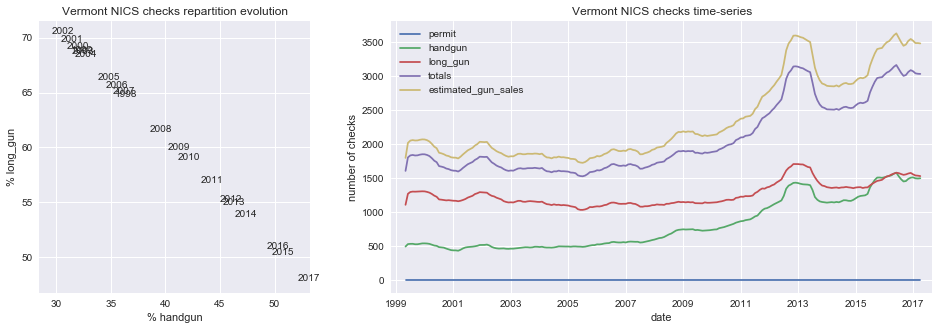

In [545]:
plot_scatter_map_ev(gun_data_df,state='Vermont')

It is interesting to observe the switch of trends between handgun and long guns sales. Even in states with strong rural background such as Vermont, sales of handgun tend to overwhelm long guns ones these latest years.

<a id='Q4'></a>
### Q4 Correlation of NICS checks with census data
> identify census facts most correlated to NICS checks

Below function and code:
- calculate the correlation between both dataset 
- print out the result sorted by correlation to 'long_gun' checks

In [546]:
# main fucntion, calculate correlation between a 'fact' column and gun_data_df
def corr_fact_to_gun_data(fact_column,gun_data_df,state='all',raw_column=False):
    # read period from fact column
    start_date=fact_column.start
    end_date=fact_column.end
    # and drop useless rows
    fact_column=fact_column.drop(['start','end','unit'])
    # copy
    df=gun_data_df.copy()

    if state!='all':
        fact_column=fact_column[fact_column.index.isin(state)]
        df=df[df.state.isin(state)]
        
    # filter gun_data_df on the period of the fact
    df=df[(df.index>=pd.to_datetime(start_date,format="%Y-%m"))&(df.index<=pd.to_datetime(end_date,format="%Y-%m"))]
    # group by state and calculate mean on the period
    df_mean=df.groupby('state').mean()
    # concatenate with fact column
    merged=pd.concat([df_mean,fact_column.astype(float)],axis=1)
    #print(merged)
    # return correlation w/o fact row/column
    return merged.corr().iloc[:-1,-1:]

def main_loop(state='all'):
    # build the whole correlation matrix
    correlation_matrix=pd.DataFrame()
    # loop on fact columns
    for fact in census_data_df.columns:
        
        fact_column = census_data_df[fact]
        
        # concatenate results
        correlation_matrix=pd.concat([correlation_matrix,corr_fact_to_gun_data(fact_column,gun_data_df,state)],axis=1)
        #break
    # transpose for readability
    corr_census_to_gun=correlation_matrix.transpose()
    # print
    return corr_census_to_gun

corr_census_to_gun=main_loop()
corr_census_to_gun.sort_values('long_gun',ascending=False)

permit  handgun  long_gun  \
Population estimates, July 1, 2016,  (V2016)          0.27     0.79      0.90   
Housing units,  July 1, 2016,  (V2016)                0.27     0.81      0.90   
Building permits, 2016                                0.17     0.77      0.86   
Veterans, 2011-2015                                   0.19     0.87      0.85   
Households, 2011-2015                                 0.21     0.79      0.80   
Total employment, 2015                                0.24     0.76      0.80   
Total nonemployer establishments, 2015                0.22     0.74      0.79   
Total employer establishments, 2015                   0.23     0.73      0.77   
Total annual payroll, 2015 ($1,000)                   0.23     0.68      0.73   
Total manufacturers shipments, 2012 ($1,000)          0.20     0.70      0.71   
Veteran-owned firms, 2012                             0.10     0.77      0.71   
Total retail sales, 2012 ($1,000)                     0.11     0.73      0.70   
Nonminority-owned firms, 2012                         0.14     0.67      0.70   
Housing units, April 1, 2010                          0.09     0.71      0.67   
Total health care and social assistance receipt...    0.12     0.64      0.67   
Men-owned firms, 2012                                 0.11     0.69      0.65   
Population estimates base, April 1, 2010,  (V2016)    0.09     0.69      0.65   
Population, Census, April 1, 2010                     0.09     0.69      0.65   
All firms, 2012                                       0.11     0.70      0.64   
Total merchant wholesaler sales, 2012 ($1,000)        0.14     0.69      0.64   
Nonveteran-owned firms, 2012                          0.11     0.69      0.64   
Women-owned firms, 2012                               0.10     0.71      0.62   
Total accommodation and food services sales, 20...    0.09     0.67      0.60   
Minority-owned firms, 2012                            0.06     0.70      0.54   
Hispanic or Latino, percent, July 1, 2016,  (V2...    0.02     0.36      0.43   
Persons in poverty, percent                           0.22     0.28      0.30   
Mean travel time to work (minutes), workers age...    0.07     0.31      0.28   
Persons  without health insurance, under age 65...   -0.14     0.37      0.28   
Total employment, percent change, 2014-2015           0.22     0.24      0.28   
Language other than English spoken at home, per...   -0.00     0.35      0.25   
...                                                    ...      ...       ...   
Persons per household, 2011-2015                      0.07     0.22      0.15   
Persons under 18 years, percent, July 1, 2016, ...    0.05    -0.00      0.13   
Land area in square miles, 2010                      -0.04     0.19      0.12   
Population, percent change - April 1, 2010 (est...   -0.08     0.21      0.11   
Persons under 5 years, percent, July 1, 2016,  ...    0.02    -0.04      0.09   
With a disability, under age 65 years, percent,...    0.17     0.03      0.08   
Living in same house 1 year ago, percent of per...    0.05    -0.07      0.06   
Persons under 18 years, percent, April 1, 2010        0.14     0.14      0.05   
Asian alone, percent, July 1, 2016,  (V2016)         -0.02     0.00      0.05   
Persons 65 years and over, percent, April 1, 2010    -0.13    -0.13     -0.01   
Persons under 5 years, percent, April 1, 2010         0.12     0.09     -0.02   
Median gross rent, 2011-2015                         -0.11     0.06     -0.03   
White alone, percent, July 1, 2016,  (V2016)          0.08    -0.05     -0.08   
Population per square mile, 2010                     -0.06    -0.07     -0.08   
Median selected monthly owner costs -with a mor...   -0.09    -0.04     -0.09   
Bachelor's degree or higher, percent of persons...   -0.14    -0.10     -0.14   
Two or More Races, percent, July 1, 2016,  (V2016)   -0.10    -0.15     -0.15   
Per capita income in past 12 months (in 2015 do...   -0.14    -0.13     -0.16   
Na

- Above matrix provides for each census 'fact', its correlation with NICS checks categories on the period

##### Partial observation / conclusion
- As expected, based on preceding analysis, 'permit' checks are poorly correlated to census data. This category of checks highly depends on state laws specificities. This variability downgrades the correlation with demography.
- 2016 population estimates is the 'fact' most correlated to 'permit' and 'long_gun' NICS check category. 
- Veterans, 2011-2015 is the most correlated to 'handgun' category, but the gap with 2016 population estimates is not that important
- There is a big question mark on the gap between 2010 and 2016 population estimates correlation values. The difference is very significant and <B>requires additional analysis</B> to explain it.
- Population pyramid of ages is not really correlated to any NICS checks. This makes sense as this distribution should be rather uniform between states. However, a closer look for elders (>65) between 2010/2016 might be interesting as they seem slightly negatively correlated to long_gun checks.
- There is only one census 'fact' negatively correlated to NICS checks 'High school graduate or higher, percent of persons age 25 years+, 2011-2015'. However 'Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015' is not although it is slightly negative as well. Thus any correlation with states education system doesn't sound obvious.

<I>To persue this analysis & to focus on most relevant categories, any correlation  with maximum per category &lt;40% is removed.</I>


In [547]:
all_states = set(census_data_df[:-3].index.values)
states_to_be_discarded={'Hawaii','Kentucky','Illinois','North Carolina','Pennsylvania','Iowa','Nebraska','California','Texas','Florida'}
#states_to_be_discarded={'Kentucky'}
states_to_be_studied = all_states - states_to_be_discarded

corr_census_to_gun=main_loop(states_to_be_studied)
corr_census_to_gun.sort_values('long_gun',ascending=False)

permit  handgun  long_gun  \
Veterans, 2011-2015                                   0.28     0.75      0.78   
Total manufacturers shipments, 2012 ($1,000)          0.41     0.64      0.75   
Housing units,  July 1, 2016,  (V2016)                0.31     0.62      0.71   
Veteran-owned firms, 2012                             0.33     0.55      0.70   
Population estimates, July 1, 2016,  (V2016)          0.30     0.60      0.69   
Households, 2011-2015                                 0.27     0.56      0.67   
Nonminority-owned firms, 2012                         0.38     0.47      0.66   
Total retail sales, 2012 ($1,000)                     0.34     0.50      0.65   
Housing units, April 1, 2010                          0.12     0.50      0.65   
Building permits, 2016                                0.32     0.64      0.64   
Total employment, 2015                                0.29     0.51      0.63   
Population estimates base, April 1, 2010,  (V2016)    0.13     0.48      0.62   
Population, Census, April 1, 2010                     0.13     0.48      0.62   
Total employer establishments, 2015                   0.23     0.46      0.60   
All firms, 2012                                       0.30     0.39      0.60   
Women-owned firms, 2012                               0.29     0.38      0.60   
Total nonemployer establishments, 2015                0.22     0.46      0.58   
Nonveteran-owned firms, 2012                          0.29     0.37      0.58   
Total health care and social assistance receipt...    0.31     0.39      0.58   
Men-owned firms, 2012                                 0.28     0.37      0.57   
Total annual payroll, 2015 ($1,000)                   0.20     0.38      0.51   
Total accommodation and food services sales, 20...    0.24     0.34      0.50   
Total merchant wholesaler sales, 2012 ($1,000)        0.26     0.28      0.42   
Minority-owned firms, 2012                            0.11     0.20      0.42   
Persons in poverty, percent                          -0.12     0.29      0.39   
With a disability, under age 65 years, percent,...   -0.17     0.23      0.29   
Black or African American alone, percent, July ...    0.09     0.28      0.29   
Female persons, percent,  July 1, 2016,  (V2016)      0.12     0.27      0.24   
Female persons, percent, April 1, 2010               -0.06     0.22      0.22   
Mean travel time to work (minutes), workers age...    0.07     0.21      0.20   
...                                                    ...      ...       ...   
Persons under 5 years, percent, April 1, 2010         0.49     0.05      0.05   
Total employment, percent change, 2014-2015           0.28     0.09      0.03   
Asian alone, percent, July 1, 2016,  (V2016)         -0.04     0.01      0.03   
Living in same house 1 year ago, percent of per...   -0.01    -0.10     -0.01   
Persons 65 years and over, percent, April 1, 2010    -0.40    -0.10     -0.03   
Two or More Races, percent, July 1, 2016,  (V2016)   -0.16    -0.03     -0.03   
Persons per household, 2011-2015                      0.37    -0.04     -0.06   
Land area in square miles, 2010                      -0.04    -0.08     -0.07   
Owner-occupied housing unit rate, 2011-2015           0.19    -0.07     -0.08   
Population, percent change - April 1, 2010 (est...    0.11    -0.02     -0.08   
White alone, not Hispanic or Latino, percent, J...    0.09    -0.10     -0.09   
Persons 65 years and over, percent,  July 1, 20...   -0.14    -0.08     -0.10   
Hispanic or Latino, percent, July 1, 2016,  (V2...   -0.14    -0.09     -0.12   
Native Hawaiian and Other Pacific Islander alon...   -0.04    -0.12     -0.14   
Foreign born persons, percent, 2011-2015              0.01    -0.11     -0.14   
Language other than English spoken at home, per...   -0.03    -0.15     -0.21   
White alone, percent, July 1, 2016,  (V2016)          0.02    -0.19     -0.21   
Median gross rent, 2011-2015                         -0.05    -0.15     -0.24   
Am

In [548]:
corr_census_to_gun=corr_census_to_gun[corr_census_to_gun.abs().max(axis=1)>0.4].sort_values('long_gun',ascending=False)
corr_census_to_gun

permit  handgun  long_gun  \
Veterans, 2011-2015                                   0.28     0.75      0.78   
Total manufacturers shipments, 2012 ($1,000)          0.41     0.64      0.75   
Housing units,  July 1, 2016,  (V2016)                0.31     0.62      0.71   
Veteran-owned firms, 2012                             0.33     0.55      0.70   
Population estimates, July 1, 2016,  (V2016)          0.30     0.60      0.69   
Households, 2011-2015                                 0.27     0.56      0.67   
Nonminority-owned firms, 2012                         0.38     0.47      0.66   
Total retail sales, 2012 ($1,000)                     0.34     0.50      0.65   
Housing units, April 1, 2010                          0.12     0.50      0.65   
Building permits, 2016                                0.32     0.64      0.64   
Total employment, 2015                                0.29     0.51      0.63   
Population estimates base, April 1, 2010,  (V2016)    0.13     0.48      0.62   
Population, Census, April 1, 2010                     0.13     0.48      0.62   
Total employer establishments, 2015                   0.23     0.46      0.60   
All firms, 2012                                       0.30     0.39      0.60   
Women-owned firms, 2012                               0.29     0.38      0.60   
Total nonemployer establishments, 2015                0.22     0.46      0.58   
Nonveteran-owned firms, 2012                          0.29     0.37      0.58   
Total health care and social assistance receipt...    0.31     0.39      0.58   
Men-owned firms, 2012                                 0.28     0.37      0.57   
Total annual payroll, 2015 ($1,000)                   0.20     0.38      0.51   
Total accommodation and food services sales, 20...    0.24     0.34      0.50   
Total merchant wholesaler sales, 2012 ($1,000)        0.26     0.28      0.42   
Minority-owned firms, 2012                            0.11     0.20      0.42   
Persons under 18 years, percent, April 1, 2010        0.57     0.09      0.08   
Persons under 5 years, percent, April 1, 2010         0.49     0.05      0.05   
Persons 65 years and over, percent, April 1, 2010    -0.40    -0.10     -0.03   

                                                    totals  \
Veterans, 2011-2015                                   0.74   
Total manufacturers shipments, 2012 ($1,000)          0.78   
Housing units,  July 1, 2016,  (V2016)                0.57   
Veteran-owned firms, 2012                             0.68   
Population estimates, July 1, 2016,  (V2016)          0.55   
Households, 2011-2015                                 0.62   
Nonminority-owned firms, 2012                         0.64   
Total retail sales, 2012 ($1,000)                     0.65   
Housing units, April 1, 2010                          0.53   
Building permits, 2016                                0.57   
Total employment, 2015                                0.53   
Population estimates base, April 1, 2010,  (V2016)    0.52   
Population, Census, April 1, 2010                     0.52   
Total employer establishments, 2015                   0.46   
All firms, 2012                                       0.55   
Women-owned firms, 2012                               0.55   
Total nonemployer establishments, 2015                0.46   
Nonveteran-owned firms, 2012                          0.53   
Total health care and social assistance receipt...    0.55   
Men-owned firms, 2012                                 0.52   
Total annual payroll, 2015 ($1,000)                   0.39   
Total accommodation and food services sales, 20...    0.46   
Total merchant wholesaler sales, 2012 ($1,000)        0.41   
Minority-owned firms, 2012                            0.32   
Persons under 18 years, percent, April 1, 2010        0.44   
Persons under 5 years, percent, April 1, 2010         0.36   
Persons 65 years and over, percent, April 1, 2010    -0.31   

                                              

There are still many facts left. But all these facts are actually directly proportional to the demography. This can be easily demonstrated by calculating autocorrelation of census facts:

In [549]:
c=census_data_df[:-3][corr_census_to_gun.index.values].astype(float).corr()
c.iloc[:,0]

Fact
Veterans, 2011-2015                                                        1.00
Total manufacturers shipments, 2012 ($1,000)                               0.80
Housing units,  July 1, 2016,  (V2016)                                     0.98
Veteran-owned firms, 2012                                                  0.98
Population estimates, July 1, 2016,  (V2016)                               0.96
Households, 2011-2015                                                      0.97
Nonminority-owned firms, 2012                                              0.95
Total retail sales, 2012 ($1,000)                                          0.97
Housing units, April 1, 2010                                               0.98
Building permits, 2016                                                     0.89
Total employment, 2015                                                     0.96
Population estimates base, April 1, 2010,  (V2016)                         0.96
Population, Census, April 1, 2010  

For detailed analysis of the correlation with NICS checks, we'll focus only on these three categories 
- Population estimates, July 1, 2016,  (V2016)
- Hispanic or Latino, percent, July 1, 2016,  (V2016)  
- High school graduate or higher, percent of persons age 25 years+, 2011-2015
    
Before analysing these correlations, we'll try to find out why the 2010 population estimates is less correlated then 2016 to NICS long_gun and handgun checks. The most likely hypothesis is that most populous states drive the correlation. To throw light upon this assumption, we'll first plot the absolute growth of population per state between 2010 and 2016 and calculate some statistics on population estimates:

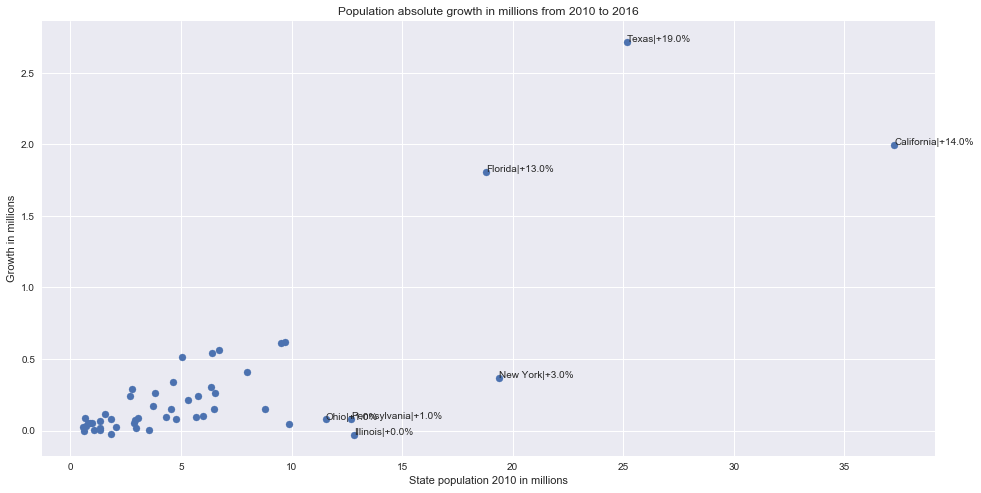

In [550]:
pop_2016=census_data_df.iloc[:-3,0].astype(float)/1e6
pop_2010=census_data_df.iloc[:-3,1].astype(float)/1e6
delta=pop_2016-pop_2010
total=delta.sum()
inc=delta/total*100
inc=inc.round()
plt.figure(figsize=(16,8))
plt.scatter(pop_2010,delta)
#sns.jointplot(pop_2010,delta)
plt.title('Population absolute growth in millions from 2010 to 2016')
plt.xlabel('State population 2010 in millions')
plt.ylabel('Growth in millions')
plt.grid(b='on')
for state in pop_2010.index:
    if pop_2010[state]>10:
        plt.annotate(state+'|+'+str(inc[state])+'%',xy=(pop_2010[state],delta[state]))

Population estimates base, April 1, 2010,  (V2016)  \
count                                              50.00    
mean                                                6.16    
std                                                 6.85    
min                                                 0.56    
25%                                                 1.83    
50%                                                 4.44    
75%                                                 6.68    
max                                                37.25    

       Population estimates, July 1, 2016,  (V2016)  
count                                         50.00  
mean                                           6.45  
std                                            7.27  
min                                            0.59  
25%                                            1.85  
50%                                            4.56  
75%                                            7.20  
max                                           39.25

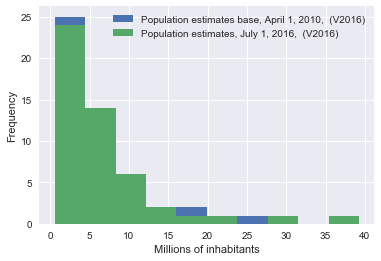

In [551]:
ax=plt.figure(figsize=(18,5))
population=pd.concat([pop_2010,pop_2016],axis=1)
population.plot(kind='hist')
plt.xlabel('Millions of inhabitants')
(population).describe()

- Demography of US is balanced between a vast majority of states with few population and few states with a very important population. This can be seen on the histogram and statistics calculated above: 75% of states are below 7.2 millions whereas California weights 39.2 millions. When correlation with NICS checks is calculated, the weight of highly populated states (high z-score) is predominant.
- As we can see on the scatter plot, roughly half of total US population growth between 2010 and 2016 is shared by three states: Florida, Texas and California. 
- As we know fom previous analysis, NICS checks raise is consistent, e.g there is a significant raise between 2010 and 2016 with a visible increase of the trend. So basically the weight of highly populated states should have been increased in the correlation factor with census data as well.
- This might explain why the correlation coefficient between NICS checks and population estimates grows significantively between 2010 and 2016 (from roughly 0.7 to 0.9 for long_gun)
- This might explain as well why the correlation with 'Hispanic or Latino, percent, July 1, 2016,  (V2016)' and NICS checks is significant (around 0.5) because top three states have a significant spanish speaking population.

In order to consolidate these assumptions, below function calculates for each state its contribution to the whole correlation with a census fact. We'll use this function to calculate the difference between 2016 and 2010 correlation contribution for each state.

In [552]:
def calc_corr_contribution_per_states(fact_column,gun_data_df):
    # read period from fact column
    start_date=fact_column.start
    end_date=fact_column.end
    # and drop useless rows
    fact_column=fact_column.drop(['start','end','unit'])
    # copy
    df=gun_data_df.copy()
        
    # filter gun_data_df on the period of the fact
    df=df[(df.index>=pd.to_datetime(start_date,format="%Y-%m"))&(df.index<=pd.to_datetime(end_date,format="%Y-%m"))]
    # group by state and calculate mean on the period
    df_mean=df.groupby('state').mean()
    # calculate contribution to pearson correlation of each state and convert in %
    fact_column=(fact_column-fact_column.mean())/fact_column.std(ddof=0)
    df_mean=(df_mean-df_mean.mean())/df_mean.std(ddof=0)
    return df_mean.mul(fact_column,axis=0)/len(df_mean.index.values)*100
                                      

In [553]:
# call function for 2016 & 2010 pop census data
corr_2016=calc_corr_contribution_per_states(census_data_df.iloc[:,0],gun_data_df).sort_values('long_gun',ascending=False)
corr_2010=calc_corr_contribution_per_states(census_data_df.iloc[:,1],gun_data_df).sort_values('long_gun',ascending=False)

In [554]:
# print out top 5 contributors for 'long_gun' correlation
delta=(corr_2016-corr_2010)
delta.sort_values('long_gun',ascending=False).head(5)

permit handgun long_gun totals estimated_gun_sales
state                                                        
California   8.16    2.12    20.15   9.10                8.21
Texas        1.35   -3.01     4.73  -0.11               -0.99
Florida      1.95   -0.12     3.93   2.36                2.26
New York    -0.43    0.20     0.81  -0.32                0.02
Ohio         0.32   -0.52     0.60   0.23                0.03

In [555]:
# print out top 5 contributors for 'handung' correlation
delta.sort_values('handgun',ascending=False).head(5)

permit handgun long_gun totals estimated_gun_sales
state                                                          
Pennsylvania   0.93    6.66    -9.04  -0.20               -1.90
California     8.16    2.12    20.15   9.10                8.21
Illinois       1.56    1.11     0.56   1.49                0.97
Michigan      -0.27    0.78    -0.25  -0.14                0.23
Alabama       -0.17    0.28     0.17  -0.03                0.25

- This rather long computation confirms the initial assumption. Most populated states contribution to NICS 'long_gun' checks correlation has significantively raised between 2010 and 2016. Actually, california alone gathers 20% of the correlation growth, followed by Texas (5%) and Florida (3%)
- For 'handgun' correlation, Pennsylvania is the biggest contributor (almost 2/3 of the correlation growth)

What about Hispanic or Latino, percent, July 1, 2016,  (V2016)?

Hispanic or Latino, percent, July 1, 2016,  (V2016)


permit handgun long_gun totals estimated_gun_sales
state                                                        
California   8.17   12.08    20.48  13.19               15.29
Texas        1.61   16.78    19.63   9.08               18.96
Florida      0.51    7.80     4.67   3.27                6.95
Vermont      0.85    1.67     1.86   1.44                1.81
Maine        0.85    1.36     1.39   1.28                1.41

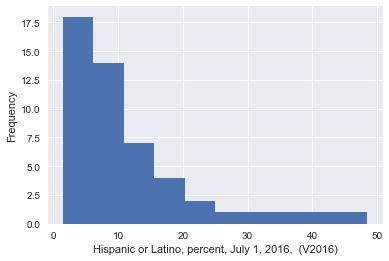

In [556]:
fact=census_data_df.iloc[:,18]
label=census_data_df.columns[18]
print(label)
(fact.iloc[:-3]*100).plot(kind='hist')
plt.xlabel(label)
calc_corr_contribution_per_states(census_data_df.iloc[:,18],gun_data_df).sort_values('long_gun',ascending=False).head(5)

- As expected, the assumption is also confirmed for 'Hispanic or Latino, percent, July 1, 2016,  (V2016)'. California, Texas and Florida are overwhelming contributors to the correlation with 'long_gun' checks (0.4 in total)
- These states have a very high percentage of hispanic population and a very high number of NICS checks as well.

Now we are going to look at 'High school graduate or higher, percent of persons age 25 years+, 2011-2015' which was the only census data rather significantivelt negatively correlated to NICS checks.

High school graduate or higher, percent of persons age 25 years+, 2011-2015
('California = ', 0.818)
('Texas = ', 0.8190000000000001)


permit handgun long_gun totals estimated_gun_sales
state                                                            
Texas           -1.15  -15.91   -15.58  -9.70              -16.59
California      -4.64   -9.77    -9.74  -8.94               -9.66
Wyoming         -1.08   -2.18    -2.31  -2.07               -2.32
Vermont         -0.99   -2.10    -2.28  -1.97               -2.27
New Hampshire   -0.83   -1.66    -2.08  -1.67               -1.97
Hawaii          -0.68   -1.84    -2.04  -1.60               -2.01
Alaska          -1.06   -1.82    -1.95  -1.85               -1.94
North Dakota    -0.90   -1.93    -1.73  -1.70               -1.90
Iowa            -0.18   -2.14    -1.65  -1.20               -1.99
Maine           -0.93   -1.59    -1.58  -1.59               -1.64
Montana         -1.15   -2.06    -1.58  -1.89               -1.88
Alabama          0.19   -1.71    -1.54  -0.78               -1.72
Nebraska        -0.46   -1.62    -1.38  -1.19               -1.57
Utah             1.12   -1.32    -1.28   0.10               -1.35
Florida          0.06   -2.60    -1.18  -1.03               -2.03
South Dakota    -0.73   -1.36    -1.17  -1.26               -1.32
North Carolina  -1.23    1.21    -1.04  -0.85                0.15
Tennessee        0.15   -1.62    -0.96  -0.62               -1.39
Louisiana        1.29   -0.48    -0.88   0.58               -0.73
New York         0.50    0.46    -0.87   0.27               -0.14
Massachusetts   -0.13   -0.58    -0.86  -0.49               -0.74
Connecticut     -0.03   -0.44    -0.74  -0.35               -0.63
Kansas          -0.46   -0.50    -0.51  -0.63               -0.51
Idaho           -0.28   -0.59    -0.50  -0.51               -0.57
Maryland        -0.30   -0.36    -0.41  -0.44               -0.41
Georgia         -0.07   -0.69    -0.34  -0.34               -0.55
Kentucky       -16.49   -0.15    -0.34 -12.42               -0.29
Oklahoma         0.37   -0.29    -0.21   0.13               -0.29
New Jersey      -0.10   -0.15    -0.19  -0.17               -0.18
Delaware        -0.05   -0.10    -0.11  -0.10               -0.11
Indiana         -0.10   -0.16    -0.09  -0.14               -0.13
Oregon          -0.44    0.02    -0.06  -0.34               -0.05
Illinois        -0.42   -0.14    -0.05  -0.37               -0.10
Virginia        -0.02    0.04     0.03   0.00                0.03
Missouri        -0.03    0.10     0.08   0.03                0.09
Michigan         0.20   -0.30     0.11   0.09               -0.12
West Virginia    0.82    0.60     0.25   0.86                0.42
Washington      -0.03    0.73     0.29   0.27                0.54
Arizona          0.37   -0.24     0.32   0.29                0.01
Wisconsin       -0.28    0.25     0.36  -0.04                0.24
Arkansas         0.62    0.85     0.36   0.80                0.62
Minnesota        0.58   -0.53     0.37   0.38               -0.11
Colorado        -0.45    0.82     0.47   0.03                0.82
South Carolina   0.30    0.14     0.54   0.41                0.35
Ohio            -0.21    0.94     0.57   0.27                0.81
Mississippi      1.55    1.01     0.58   1.61                0.83
Rhode Island     0.56    1.23     1.38   1.15                1.34
Nevada           0.73    1.10     1.51   1.27                1.32
New Mexico       1.04    1.32     1.56   1.58                1.47
Pennsylvania     0.08    0.49     2.16   0.79                1.28

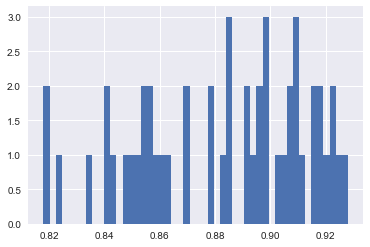

In [557]:
fact=census_data_df.iloc[:,34]
print(census_data_df.columns[34])
print('California = ', fact['California'])
print('Texas = ', fact['Texas'])
fact.iloc[:-3].hist(bins=50)
calc_corr_contribution_per_states(census_data_df.iloc[:,34],gun_data_df).sort_values('long_gun')

- Once again, main contributors are Texas and California. As they have a low percentage of population wich are at least high school graduates compared to others states and high number of checks, they contribute negatively with an important weight to the whole correlation.
- But is is rather hard to draw any conclusion.

<B>Above study relies on the whole sample</B> and thus might be biased by outliers.
If we discard Kentucky, permit category correlation greatly improves but remains lower than other categories

In [558]:
all_states = set(census_data_df[:-3].index.values)
states_to_be_discarded={'Kentucky'}
states_to_be_studied = all_states - states_to_be_discarded

corr_census_to_gun=main_loop(states_to_be_studied)
corr_census_to_gun=corr_census_to_gun[corr_census_to_gun.abs().max(axis=1)>0.4]
corr_census_to_gun.sort_values('long_gun',ascending=False)

permit  handgun  long_gun  \
Population estimates, July 1, 2016,  (V2016)          0.60     0.79      0.90   
Housing units,  July 1, 2016,  (V2016)                0.59     0.81      0.90   
Building permits, 2016                                0.42     0.77      0.87   
Veterans, 2011-2015                                   0.51     0.87      0.85   
Households, 2011-2015                                 0.56     0.79      0.80   
Total employment, 2015                                0.66     0.76      0.80   
Total nonemployer establishments, 2015                0.62     0.74      0.79   
Total employer establishments, 2015                   0.64     0.73      0.77   
Total annual payroll, 2015 ($1,000)                   0.64     0.68      0.74   
Total manufacturers shipments, 2012 ($1,000)          0.53     0.70      0.71   
Veteran-owned firms, 2012                             0.43     0.77      0.71   
Total retail sales, 2012 ($1,000)                     0.47     0.73      0.70   
Nonminority-owned firms, 2012                         0.50     0.67      0.70   
Housing units, April 1, 2010                          0.36     0.72      0.67   
Total health care and social assistance receipt...    0.46     0.64      0.67   
Men-owned firms, 2012                                 0.45     0.69      0.66   
Population estimates base, April 1, 2010,  (V2016)    0.39     0.70      0.65   
Population, Census, April 1, 2010                     0.39     0.70      0.65   
All firms, 2012                                       0.45     0.70      0.65   
Total merchant wholesaler sales, 2012 ($1,000)        0.49     0.69      0.64   
Nonveteran-owned firms, 2012                          0.45     0.69      0.64   
Women-owned firms, 2012                               0.44     0.71      0.62   
Total accommodation and food services sales, 20...    0.43     0.67      0.60   
Minority-owned firms, 2012                            0.36     0.70      0.54   
Hispanic or Latino, percent, July 1, 2016,  (V2...    0.24     0.36      0.43   
Persons under 18 years, percent, April 1, 2010        0.48     0.15      0.05   
High school graduate or higher, percent of pers...   -0.20    -0.48     -0.47   

                                                    totals  \
Population estimates, July 1, 2016,  (V2016)          0.83   
Housing units,  July 1, 2016,  (V2016)                0.83   
Building permits, 2016                                0.71   
Veterans, 2011-2015                                   0.88   
Households, 2011-2015                                 0.85   
Total employment, 2015                                0.85   
Total nonemployer establishments, 2015                0.82   
Total employer establishments, 2015                   0.82   
Total annual payroll, 2015 ($1,000)                   0.79   
Total manufacturers shipments, 2012 ($1,000)          0.87   
Veteran-owned firms, 2012                             0.85   
Total retail sales, 2012 ($1,000)                     0.85   
Nonminority-owned firms, 2012                         0.83   
Housing units, April 1, 2010                          0.81   
Total health care and social assistance receipt...    0.79   
Men-owned firms, 2012                                 0.80   
Population estimates base, April 1, 2010,  (V2016)    0.81   
Population, Census, April 1, 2010                     0.81   
All firms, 2012                                       0.80   
Total merchant wholesaler sales, 2012 ($1,000)        0.81   
Nonveteran-owned firms, 2012                          0.79   
Women-owned firms, 2012                               0.79   
Total accommodation and food services sales, 20...    0.76   
Minority-owned firms, 2012                            0.71   
Hispanic or Latino, percent, July 1, 2016,  (V2...    0.36   
Persons under 18 years, percent, April 1, 2010        0.32   
High school graduate or higher, percent of pers...   -0.45   

                                              

If we dicard also most populous states, we obtain a lower correlaion for long_gun and handgun categories.

In [559]:
all_states = set(census_data_df[:-3].index.values)
states_to_be_discarded={'Kentucky','California','Texas','Florida','New York'}
#states_to_be_discarded={'Kentucky'}
states_to_be_studied = all_states - states_to_be_discarded

corr_census_to_gun=main_loop(states_to_be_studied)
corr_census_to_gun=corr_census_to_gun[corr_census_to_gun.abs().max(axis=1)>0.4]
corr_census_to_gun.sort_values('long_gun',ascending=False)

permit  handgun  long_gun  \
Veterans, 2011-2015                                   0.47     0.76      0.79   
Housing units,  July 1, 2016,  (V2016)                0.57     0.77      0.75   
Households, 2011-2015                                 0.57     0.70      0.74   
Population estimates, July 1, 2016,  (V2016)          0.57     0.76      0.73   
Total health care and social assistance receipt...    0.55     0.44      0.67   
Total retail sales, 2012 ($1,000)                     0.55     0.50      0.67   
Nonminority-owned firms, 2012                         0.59     0.49      0.66   
Building permits, 2016                                0.31     0.45      0.66   
Housing units, April 1, 2010                          0.34     0.48      0.66   
Veteran-owned firms, 2012                             0.50     0.53      0.65   
Total nonemployer establishments, 2015                0.58     0.66      0.64   
Total employer establishments, 2015                   0.59     0.69      0.64   
Population, Census, April 1, 2010                     0.36     0.48      0.64   
Population estimates base, April 1, 2010,  (V2016)    0.36     0.48      0.64   
Total employment, 2015                                0.61     0.71      0.64   
Men-owned firms, 2012                                 0.58     0.45      0.62   
All firms, 2012                                       0.60     0.48      0.60   
Total manufacturers shipments, 2012 ($1,000)          0.54     0.52      0.59   
Nonveteran-owned firms, 2012                          0.61     0.47      0.59   
Total annual payroll, 2015 ($1,000)                   0.59     0.65      0.55   
Women-owned firms, 2012                               0.61     0.49      0.55   
Total accommodation and food services sales, 20...    0.52     0.42      0.50   
Total merchant wholesaler sales, 2012 ($1,000)        0.61     0.33      0.44   
Minority-owned firms, 2012                            0.50     0.37      0.31   
Persons under 18 years, percent, April 1, 2010        0.47     0.12     -0.06   

                                                    totals  \
Veterans, 2011-2015                                   0.82   
Housing units,  July 1, 2016,  (V2016)                0.77   
Households, 2011-2015                                 0.84   
Population estimates, July 1, 2016,  (V2016)          0.77   
Total health care and social assistance receipt...    0.83   
Total retail sales, 2012 ($1,000)                     0.85   
Nonminority-owned firms, 2012                         0.86   
Building permits, 2016                                0.48   
Housing units, April 1, 2010                          0.76   
Veteran-owned firms, 2012                             0.83   
Total nonemployer establishments, 2015                0.75   
Total employer establishments, 2015                   0.77   
Population, Census, April 1, 2010                     0.77   
Population estimates base, April 1, 2010,  (V2016)    0.77   
Total employment, 2015                                0.79   
Men-owned firms, 2012                                 0.82   
All firms, 2012                                       0.83   
Total manufacturers shipments, 2012 ($1,000)          0.80   
Nonveteran-owned firms, 2012                          0.82   
Total annual payroll, 2015 ($1,000)                   0.73   
Women-owned firms, 2012                               0.81   
Total accommodation and food services sales, 20...    0.71   
Total merchant wholesaler sales, 2012 ($1,000)        0.68   
Minority-owned firms, 2012                            0.57   
Persons under 18 years, percent, April 1, 2010        0.30   

                                                    estimated_gun_sales  
Veterans, 2011-2015                                                0.82  
Housing units,  July 1, 2016,  (V2016)                             0.80  
Households, 2011-2015                                              0.76  
Population estimates, July 1, 2016, 

<a id='Q5'></a>
### Q5 NICS checks nomalized per population

- There are only two US population estimates: April 2010 and July 2016  - To simplify the analysis, we'll keep all 2010 and 2016 NICS records and group them on the whole year, this will smooth any seasonal variation.

In [560]:
df=gun_data_df.copy()
df['year']= df.index.year.astype(str)
df=df[ (df.year=='2010') | (df.year=='2016')]

mean_per_year=df.groupby('year').mean()
print('NICS checks growth between 2010 and 2016 (%)')
print((mean_per_year.loc['2016']/mean_per_year.loc['2010']-1)*100)
print 'Average population growth between 2010 and 2016 (%) = ',(pop_2016.sum()/pop_2010.sum()-1)*100.0

NICS checks growth between 2010 and 2016 (%)
permit                138.65
handgun               116.43
long_gun               21.67
totals                 88.76
estimated_gun_sales    61.54
dtype: float64
Average population growth between 2010 and 2016 (%) =  4.63725784333


- Increase of NICS checks between 2010 and 2016 is outstanding for 'permit' and 'handgun' categories (more than the double). These figures reveals that many states have adopted NICS background checks (in lieu of states ones) for delivery of concealed permits.
- 'long_gun' increase is more in the order of magnitude of population growth but still mutiplied per almost 5. This category is less sensitive to gun laws changes among states along years. Actualy since the very begining, fro the vast majority of states, long guns just lead to a background check only at point of sales by licensed sellers. However we already knwok that there are some expections (Hawaii being the most obvious example as only permits are delivered)
- Population growth compared to NICS checks growth is at best 1/5th (for long_gun). <B>NICS checks grows really faster than population.</B>

To analyse the growth per state, we'll first build a merged dataframe.

In [561]:
# Create a 'population' dataframe
pop_2010=pd.DataFrame(pop_2010)
pop_2016=pd.DataFrame(pop_2016)
pop_2016['year']='2016'
pop_2010['year']='2010'
pop_2016.columns=['population','year']
pop_2010.columns=['population','year']
population_df=pd.concat([pop_2010,pop_2016])
population_df=population_df.reset_index()
population_df.columns=['state','population','year']

# Merge with gun data frame
gun_data_pop_df=df.groupby(['year','state']).sum().reset_index()
gun_data_pop_df=pd.merge(population_df,gun_data_pop_df)
# Normalize checks categories per 100,000 of population 
gun_data_pop_df.iloc[:,3:]= gun_data_pop_df.iloc[:,3:].div(gun_data_pop_df.population,axis=0)/1e6*1e5

Below code plots a similiar scatter diagram as the one used during <A href=Q3>previous analysis </A>:
- x axis is 'handgun' checks per 100,000 habitants
- y axis is 'long_gun' checks per 100,000 habitants
- 2010 values are indicated in light grey
- 2016 values are indicated in light blue
- Size of the dot is proportional to % of permit checks (same than previous diagram)
- For each state, a dashed green line joins 2010 and 2016 dots

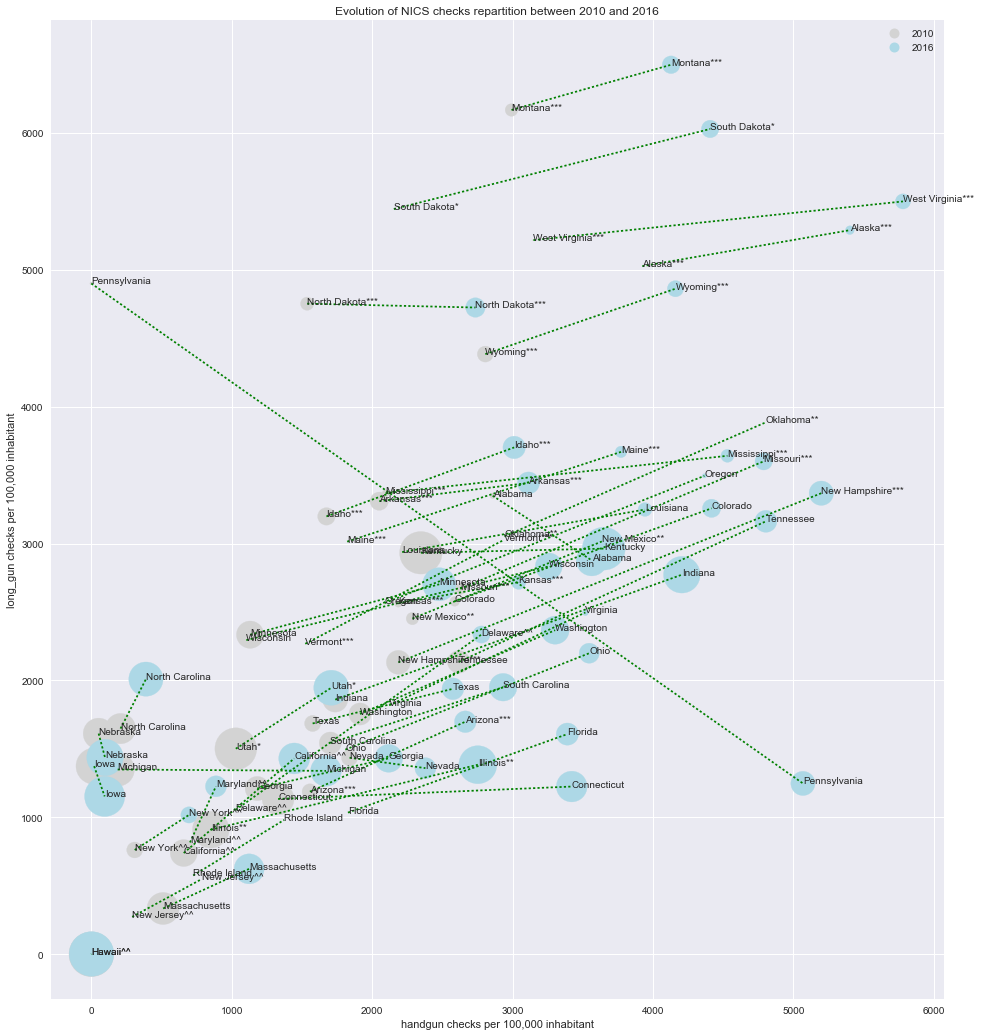

In [562]:
def set_color_year(y):
    if y=='2016':
        return('lightblue')
    else:
        return('lightgrey')
    
colors=gun_data_pop_df.year.apply(set_color_year)

ax=plt.figure(figsize=(16,18))        
ax=plt.scatter(gun_data_pop_df.handgun,gun_data_pop_df.long_gun,c=colors,
               s=(gun_data_pop_df.permit).div(gun_data_pop_df.totals,axis=0)*20*100)
annotate_state_dot(gun_data_pop_df,state_is_index=False)
z=gun_data_pop_df
x1=z[z.year=='2010'].handgun.values
x2=z[z.year=='2016'].handgun.values
y1=z[z.year=='2010'].long_gun.values
y2=z[z.year=='2016'].long_gun.values
ax=plt.plot([x1,x2],[y1,y2],'g:')
ax=plt.xlabel('handgun checks per 100,000 inhabitant')
ax=plt.ylabel('long_gun checks per 100,000 inhabitant')
texts = ['2010','2016']
colors= ['lightgrey','lightblue']
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches)
plt.title('Evolution of NICS checks repartition between 2010 and 2016')
plt.grid(b='on')

- All states apart Hawaii slide to the right part of the diagram: <B>the increase of handgun sales is a general trend without any exception within USA.</B>
- Most states slide to upper right side of the diagram as well. The general trend is an increase of both handgun & long_gun checks. However they are some noticeable exceptions:
    - Hawaii, which has already been identified as a 'full permit' state: a permit of purchase is required fo all type of firearm)
    - Pennsyvlvania, which we have already <a href="#pennsylvania">studied earlier</a> has almost an outlier pattern.
    - Alabama (see below detailed analysis)
    - and some more states which are marginally dropping down as well (such a Iowa or North Dakota), we'll identify the exhaustive list of these states later on
- An interesting observation is that we can easily identify states with a high gun ownership (see http://demographicdata.org/facts-and-figures/gun-ownership-statistics/), this is to say all states located in the upper right part of the diagram: Wyoming, Alaska, Montan a,South Dakota, West Virginia ... These states allying permissive laws and gun culture have a very number of handgun/long_gun checks per inhabitant.
- Contrary to previous representation based only ratio of check categories, custering is more efficient. When normalizing checks to population,  'permissive' states are really isolated in the upper right side of the diagram:
    - all states with unrestricted concealed carry are located in the upper right part of the diagram (see https://en.wikipedia.org/wiki/Constitutional_carry)
    - This part of the diagram doesn't include anymore a restrictive state such as 'New Jersey'

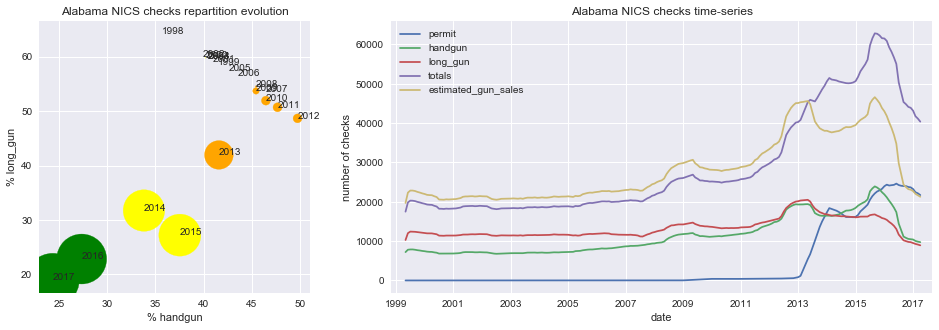

In [563]:
plot_scatter_map_ev(gun_data_df,state='Alabama')

Once again the pattern is a bit difficult to interpretate. Most likely scenario is that:
- NICS permit checks  have been introduced for concealed carry permit since 2013. 
which is confirmed by https://www.usacarry.com/alabama_concealed_carry_permit_information.html
<I> [...]As of August 1, 2013, Sheriffs to conduct a background check using the National Instant Criminal Background Check System (NICS) on all applicants.[...]</I>
- But it is rather tough to explain why long_gun and handgun categories drops that much. Maybe that carry permit allows to buy fiream handgun without any background check since 2016. But no evidence confirming this assumption can be found on internet.

For next step:
- build a datframe calculating variation in % for each NICS category normalized per inhabitants from 2010 to 2016 
- for each category of checks, rank states

In [564]:
# Building the variation dataframe
gun_data_pop_2016_df=gun_data_pop_df[gun_data_pop_df['year']=='2016']
gun_data_pop_2010_df=gun_data_pop_df[gun_data_pop_df['year']=='2010']
gun_data_pop_2010_df=gun_data_pop_2010_df.drop('year',axis=1)
gun_data_pop_2016_df=gun_data_pop_2016_df.drop('year',axis=1)
gun_data_pop_2010_df=gun_data_pop_2010_df.set_index('state',drop=True)
gun_data_pop_2016_df=gun_data_pop_2016_df.set_index('state',drop=True)
gun_data_pop_increase_2010_2016_df=((gun_data_pop_2016_df-gun_data_pop_2010_df)/(gun_data_pop_2010_df))*100
gun_data_pop_increase_2010_2016_df.sort_values('permit',ascending=False,axis=0)

population      permit     handgun  long_gun  totals  \
state                                                                  
Louisiana             3.27         inf       78.12     10.58   54.18   
Virginia              5.13         inf       65.88     37.31   55.66   
South Dakota          6.30         inf      104.59     10.75   62.12   
Delaware              6.03         inf      170.30    121.54  188.19   
Alaska                4.46         inf       37.69      5.24   24.17   
Maine                 0.23         inf      107.04     21.74   64.73   
Wisconsin             1.61 19627500.71      195.15     23.48  180.79   
Ohio                  0.67 16701890.07       96.00     47.09  117.68   
Florida               9.61   878532.38       85.51     55.41  131.74   
Maryland              4.20   864200.15       26.34     50.16   78.54   
West Virginia        -1.18    15054.60       83.58      5.42   52.17   
Pennsylvania          0.64    12808.94 10730728.78    -74.53   81.46   
Alabama               1.74     6090.47       24.68    -14.09   97.10   
Indiana               2.30      778.07      142.13     49.05  306.94   
Colorado             10.16      497.43       70.71     26.37   69.86   
Mississippi           0.69      485.68      116.17      8.10   59.60   
Oregon                6.85      460.19      108.95     36.22   69.93   
Kansas                1.90      375.65       39.23      6.04   31.50   
Missouri              1.74      287.18       82.24     34.88   73.90   
Arizona               8.43      246.09       71.09     43.04   82.09   
California            5.36      233.36      119.56     93.43  151.92   
Washington            8.38      209.78       72.62     34.89   92.62   
Minnesota             4.07      206.45      119.05     15.77  108.20   
Illinois             -0.23      198.80      223.47     52.19  177.88   
North Dakota         12.69      190.02       77.97     -0.59   33.59   
Texas                10.80      188.70       63.38     15.02   57.86   
South Carolina        7.26      188.14       72.30     26.42   84.02   
Idaho                 7.37      158.13       79.85     15.75   56.15   
Montana               5.37      147.77       37.98      5.36   26.53   
Georgia               6.42      128.28       79.23     18.21   71.75   
North Carolina        6.41      115.34       87.00     21.92   68.82   
Nevada                8.86      113.25       29.38     -5.29   27.16   
New Hampshire         1.39      109.14      137.76     57.93  101.44   
Nebraska              4.42      103.94       87.40    -10.84   45.53   
Arkansas              2.48       94.80       51.85      4.03   34.41   
Iowa                  2.88       92.29      375.60    -16.07   57.25   
New Mexico            1.06       72.85       58.98     22.96   42.84   
New York              1.89       68.18      125.22     33.61   61.07   
Connecticut           0.07       63.68      157.22      7.99   75.91   
Massachusetts         4.03       60.33      119.91     86.52   82.89   
Tennessee             4.80       56.44       83.59     48.06   64.78   
Kentucky              2.25       53.46       55.50      1.04   50.74   
Hawaii                5.02       50.40         inf       inf   50.88   
Michigan              0.45       39.09      791.48     -0.74   64.02   
Wyoming               3.86       29.93       48.26     10.89   26.04   
Utah                 10.40      -66.39       66.08     29.66  -52.33   
New Jersey            1.73         nan      169.80    100.82  136.40   
Oklahoma              4.58         nan       63.22     27.26   44.91   
Rhode Island          0.33         nan       89.23     70.45   80.92   
Vermont              -0.18         nan       92.72     33.41   57.25   

                estimated_gun_sales  
state                                
Louisiana                     41.71  
Virginia                      47.93  
South Dakota                  39.26  
Delaware                     146.77  
Alaska                        20.54  
Maine

In [565]:
def plot_ranked_states(df,category,figsize=(18,3),logy=False, plot_min=False):
    # plot ranking for 'permit' category
    plt.figure(figsize=figsize)
    tmp=df.sort_values(category,ascending=False)
    tmp=tmp[category]
    ax=tmp.plot(kind='bar',logy=logy)
    handles, labels = ax.get_legend_handles_labels()
    v=df[category]
    q=v.quantile([0.25,0.75])
    iq=q.iloc[1]-q.iloc[0]
    qmax=q.iloc[1]+1.5*iq
    qmin=q.iloc[0]-1.5*iq
    ax=plt.axhline(qmax,color='red')
    handles += [ax]
    labels += ['Q3+1.5*IQ limit (% variation of ' +str(category)+' between 2010 and 2016)']    
    if plot_min:
        plt.axhline(qmin,color='orange')
        ax=plt.axhline(qmax,color='orange')
        handles += [ax]
        labels += ['Q1-1.5*IQ limit (% variation of ' +str(category)+' between 2010 and 2016)']            
    plt.title('States ranked per '+str(category)+' variation in % between 2010 and 2016')
    plt.ylabel('% variation') 
    plt.legend(handles,labels)
    
    return ax

##### permit category

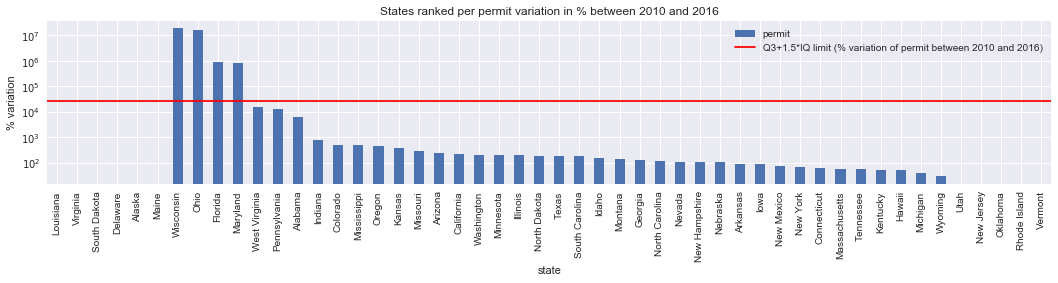

In [566]:
plot_ranked_states(gun_data_pop_increase_2010_2016_df,category='permit',logy=True)

- Scaterring of % increase between 2010 and 2016 of 'permit' category is very important. It varies from 0 to infinite (when there are no records in 2010, there is a division per 0). Even if we exclude null and infinite values, range varies from -43 to 19627500.7! That's why a logy representation is used. Consequently, null values are either infinite (left side), negative (Utah) or null (right side).
- Red line is the outlier limit (Q3+1.5IQ). The number of states which are outliers candidate is very high (10/50=20%)
- Nonetheless, we can identify three clusters of states:
    - late adopters (from Louisiana to Alabama), these states were either not or seldom using NICS checks for permit deliveries in 2010 and tend to adopt the system progressively (&lt;=2016)
    - in-progress states (from Indiana to Wyoming,) these states had already adopted  NICS checks for permit deliveries since &lt;=2010 and trend is consolidated or steady in 2016. <I>See two sample states below</I>
    - reluctant states (From New Jersey to Vermont) which have not yet adopted NICS permit checks, either because they are extremely permissive states such as Vermont or because states rely on their own background check system for permit deliveries (such as New Jersey)
    
 - Utah (see below) follows an unsual pattern: there is a massive increase of permit checks from 2010 to 2012, this explains why we observe a decrease in permits checks in 2016 compared to 2010. If we put aside this outlier pattern Utah would be classified in the 'in-progress' cluster.
 
-<B>The evolution of 'Permit' category reflects the increasing adherence of states gun laws to the federal background checks system</B>

-<B>Scattering between states doesn't allow any relevant correlation with census data</B>

Late adopters of NICS checks for permit deliveries


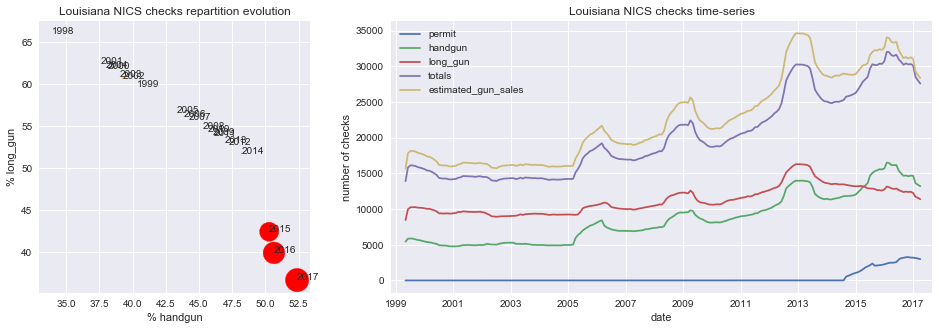

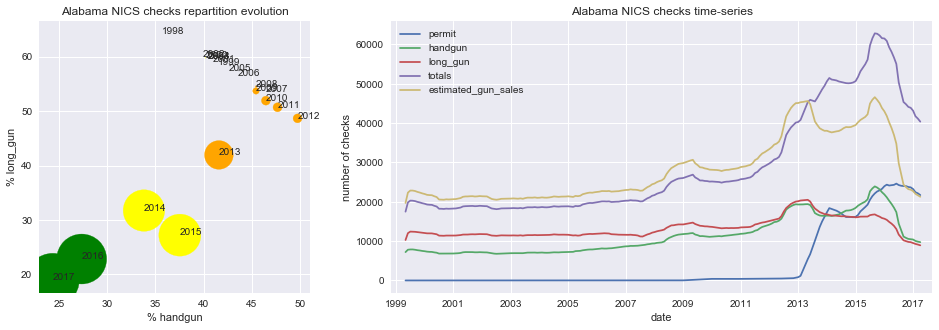

In [567]:
print('Late adopters of NICS checks for permit deliveries')
plot_scatter_map_ev(gun_data_df,state='Louisiana')
plot_scatter_map_ev(gun_data_df,state='Alabama')

In-progress adopters of NICS checks for permit deliveries


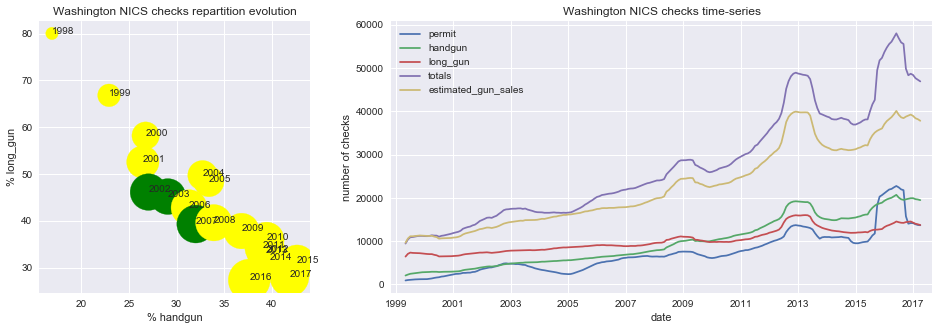

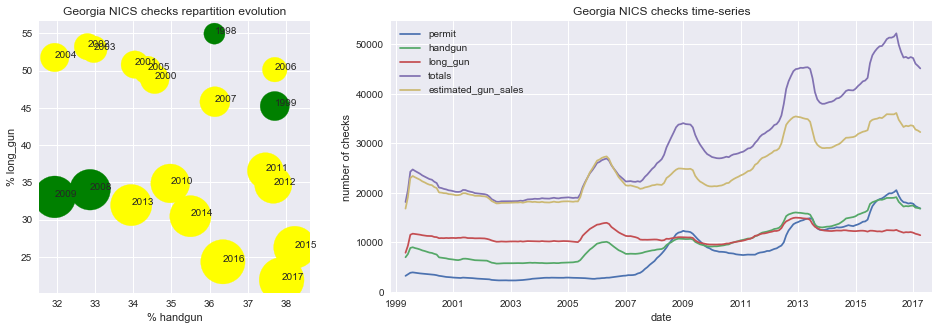

In [568]:
print('In-progress adopters of NICS checks for permit deliveries')
plot_scatter_map_ev(gun_data_df,state='Washington')
plot_scatter_map_ev(gun_data_df,state='Georgia')

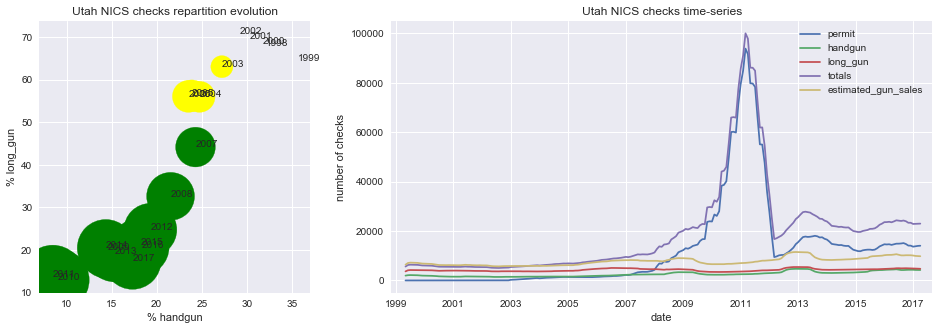

In [569]:
plot_scatter_map_ev(gun_data_df,state='Utah')

##### handgun category

In [570]:
gun_data_pop_increase_2010_2016_df

population      permit     handgun  long_gun  totals  \
state                                                                  
Alabama               1.74     6090.47       24.68    -14.09   97.10   
Alaska                4.46         inf       37.69      5.24   24.17   
Arizona               8.43      246.09       71.09     43.04   82.09   
Arkansas              2.48       94.80       51.85      4.03   34.41   
California            5.36      233.36      119.56     93.43  151.92   
Colorado             10.16      497.43       70.71     26.37   69.86   
Connecticut           0.07       63.68      157.22      7.99   75.91   
Delaware              6.03         inf      170.30    121.54  188.19   
Florida               9.61   878532.38       85.51     55.41  131.74   
Georgia               6.42      128.28       79.23     18.21   71.75   
Hawaii                5.02       50.40         inf       inf   50.88   
Idaho                 7.37      158.13       79.85     15.75   56.15   
Illinois             -0.23      198.80      223.47     52.19  177.88   
Indiana               2.30      778.07      142.13     49.05  306.94   
Iowa                  2.88       92.29      375.60    -16.07   57.25   
Kansas                1.90      375.65       39.23      6.04   31.50   
Kentucky              2.25       53.46       55.50      1.04   50.74   
Louisiana             3.27         inf       78.12     10.58   54.18   
Maine                 0.23         inf      107.04     21.74   64.73   
Maryland              4.20   864200.15       26.34     50.16   78.54   
Massachusetts         4.03       60.33      119.91     86.52   82.89   
Michigan              0.45       39.09      791.48     -0.74   64.02   
Minnesota             4.07      206.45      119.05     15.77  108.20   
Mississippi           0.69      485.68      116.17      8.10   59.60   
Missouri              1.74      287.18       82.24     34.88   73.90   
Montana               5.37      147.77       37.98      5.36   26.53   
Nebraska              4.42      103.94       87.40    -10.84   45.53   
Nevada                8.86      113.25       29.38     -5.29   27.16   
New Hampshire         1.39      109.14      137.76     57.93  101.44   
New Jersey            1.73         nan      169.80    100.82  136.40   
New Mexico            1.06       72.85       58.98     22.96   42.84   
New York              1.89       68.18      125.22     33.61   61.07   
North Carolina        6.41      115.34       87.00     21.92   68.82   
North Dakota         12.69      190.02       77.97     -0.59   33.59   
Ohio                  0.67 16701890.07       96.00     47.09  117.68   
Oklahoma              4.58         nan       63.22     27.26   44.91   
Oregon                6.85      460.19      108.95     36.22   69.93   
Pennsylvania          0.64    12808.94 10730728.78    -74.53   81.46   
Rhode Island          0.33         nan       89.23     70.45   80.92   
South Carolina        7.26      188.14       72.30     26.42   84.02   
South Dakota          6.30         inf      104.59     10.75   62.12   
Tennessee             4.80       56.44       83.59     48.06   64.78   
Texas                10.80      188.70       63.38     15.02   57.86   
Utah                 10.40      -66.39       66.08     29.66  -52.33   
Vermont              -0.18         nan       92.72     33.41   57.25   
Virginia              5.13         inf       65.88     37.31   55.66   
Washington            8.38      209.78       72.62     34.89   92.62   
West Virginia        -1.18    15054.60       83.58      5.42   52.17   
Wisconsin             1.61 19627500.71      195.15     23.48  180.79   
Wyoming               3.86       29.93       48.26     10.89   26.04   

                estimated_gun_sales  
state                                
Alabama                        4.21  
Alaska                        20.54  
Arizona                       60.22  
Arkansas                      22.81  
California                   105.71  
Color

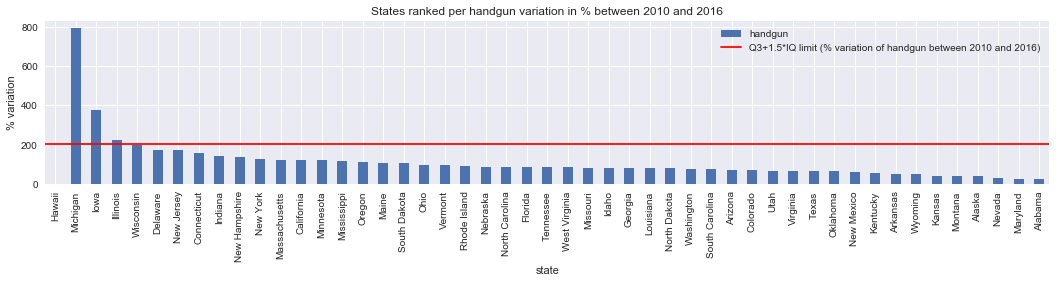

In [571]:
b=gun_data_pop_increase_2010_2016_df.index!='Pennsylvania'
plot_ranked_states(gun_data_pop_increase_2010_2016_df[b],category='handgun',logy=False)

There are three outliers:
- Pennsylvania which has already been analysed previously (not plotted)
- Michigan which follows a particular pattern as well (see below)
- and Iowa, which has already been analysed. As a reminder, this state is a 'handgun purchase permit' state (handgun~0%). There is a important relative raise in handgun checks from 2010 to 2016 on very marginal values (few percent). This raise is likely due to double checks performed by licensed sellers on top of permit.

Apart these three states, all others just seem to follow the global US trend on handgun sales at state level (see a sample below)

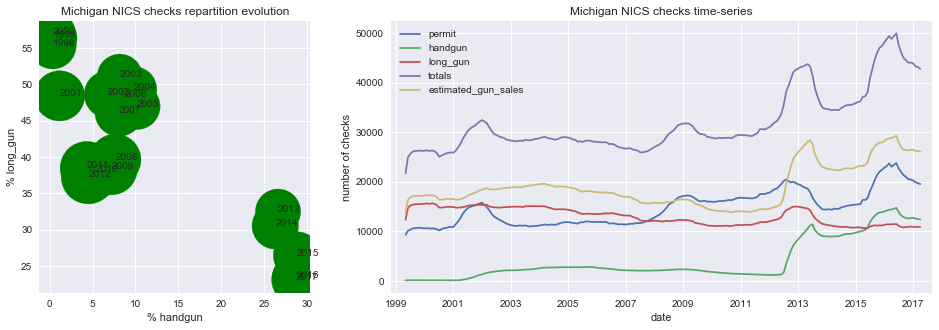

In [572]:
plot_scatter_map_ev(gun_data_df,state='Michigan')

- Michigan got rid of purchase permit for handgun from 2012, this is confirmed by wikipedia:
As of December 18, 2012, no purchase permit is required for purchases from a Class 1 FFL Dealer.[15] 

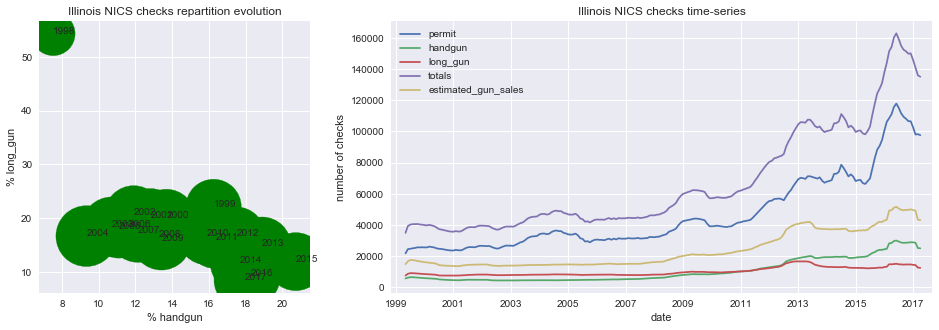

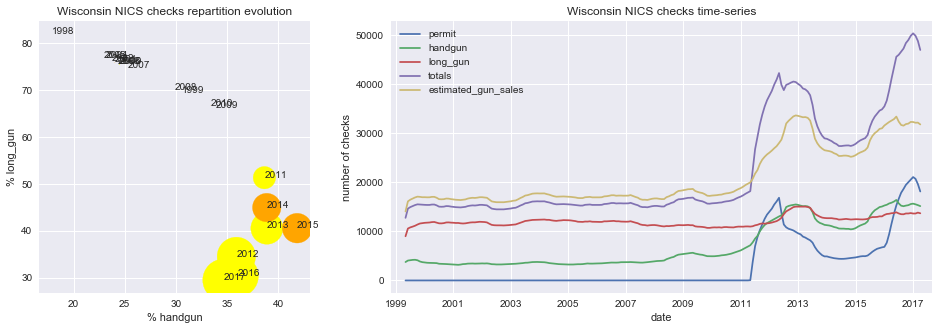

In [573]:
plot_scatter_map_ev(gun_data_df,state='Illinois')
plot_scatter_map_ev(gun_data_df,state='Wisconsin')

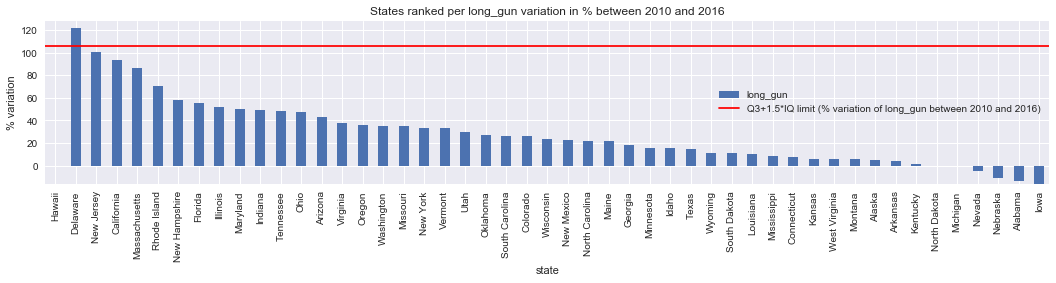

In [574]:
plot_ranked_states(gun_data_pop_increase_2010_2016_df[b],category='long_gun',logy=False)

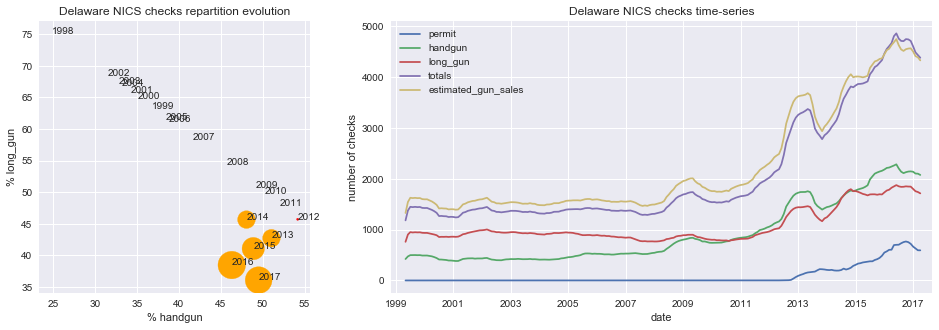

In [575]:
plot_scatter_map_ev(gun_data_df,state='Delaware')

- 'long_gun' category is the most consistent among all states.
- Apart Hawaii and Pennsylvania (not plotted), no state can really be considered as an outlier
- As underlined before, this category of checks is the least sensitive to state gun laws specificities. It corresponds to the ammount of lon gun sales in the state by licensed sellers (apart for Hawaii).

<B>NICS 'long_gun' cheks is the most relevant category to be correlated with census data as this category is the least sensitive to state gun laws variability</B>

Below regression plots for all categories illustrates this observation and confirms visually our conclusion on the increase of correlation between 2010 and 2016:

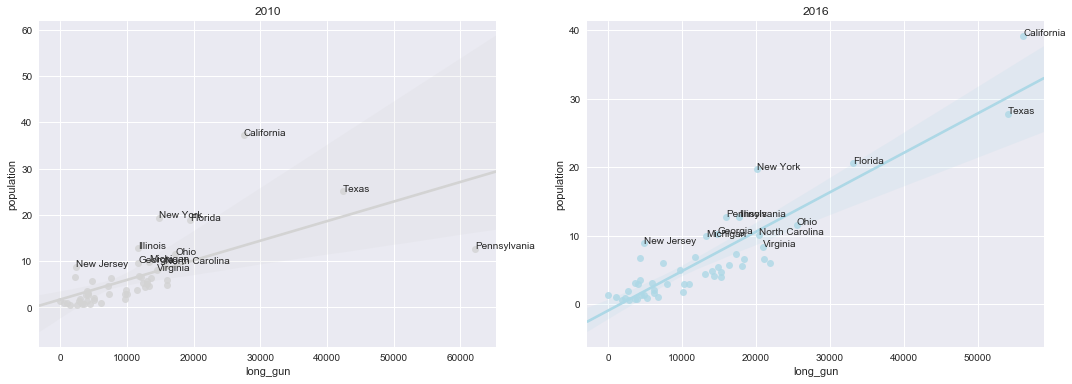

In [576]:
def plot_scatter_category(df,category='long_gun',color='blue', remove_outlier=False):
    if remove_outlier:
        df=df[df.index!='Kentucky']
    sns.regplot(df[category]*df.population,df.population,color=color)
    plt.xlabel(category)
    for state, x, y in zip(df.index,df[category]*df.population,df.population):
        if df.loc[state].population>8:
            plt.annotate(state,xy=(x,y))
    
def plot_scatter_ev(category='long_gun', remove_outlier=False):
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plot_scatter_category(gun_data_pop_2010_df,category=category,color='lightgrey',remove_outlier=remove_outlier)
    plt.title('2010')
    plt.grid(b='on')
    plt.subplot(1,2,2)
    plot_scatter_category(gun_data_pop_2016_df,category=category,color='lightblue',remove_outlier=remove_outlier)
    plt.title('2016')
    plt.grid(b='on')
    

plot_scatter_ev(category='long_gun')

As we can see, correlation with population estimates improves for 'long_gun' category between 2010 and 2016, in particular for California (as analysed before) 

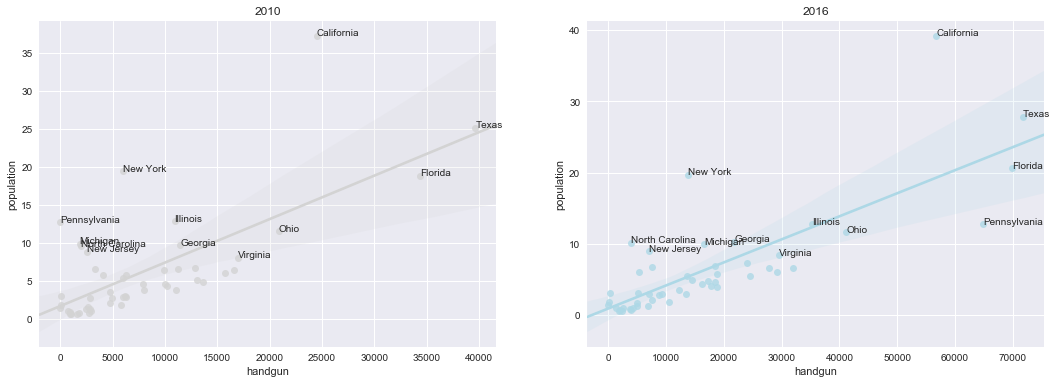

In [577]:
plot_scatter_ev(category='handgun')

- Correlation with population estimates slightly improves for 'handgun' category between 2010 and 2016, mainly due to PEnnsylvania.
- California and New York have few checks compared to their population. 

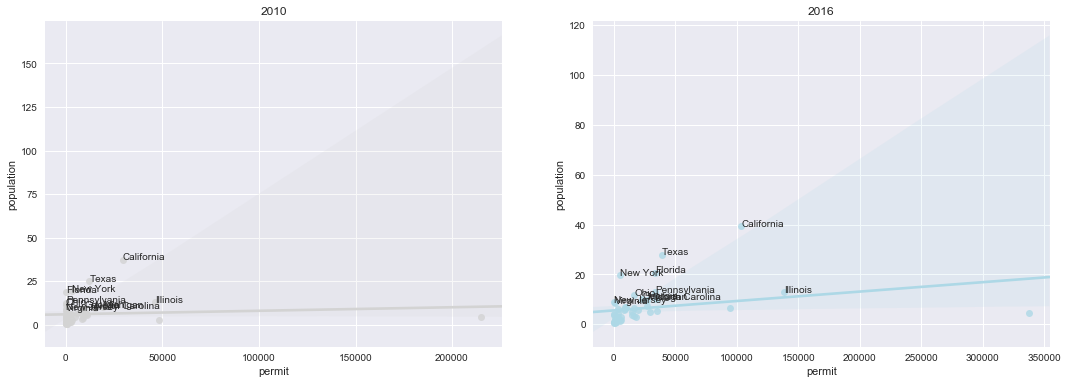

In [578]:
plot_scatter_ev(category='permit')

Scattering of permit checks is important but if we remove 'Kentucky' a rather consistent regression line can be extracted.

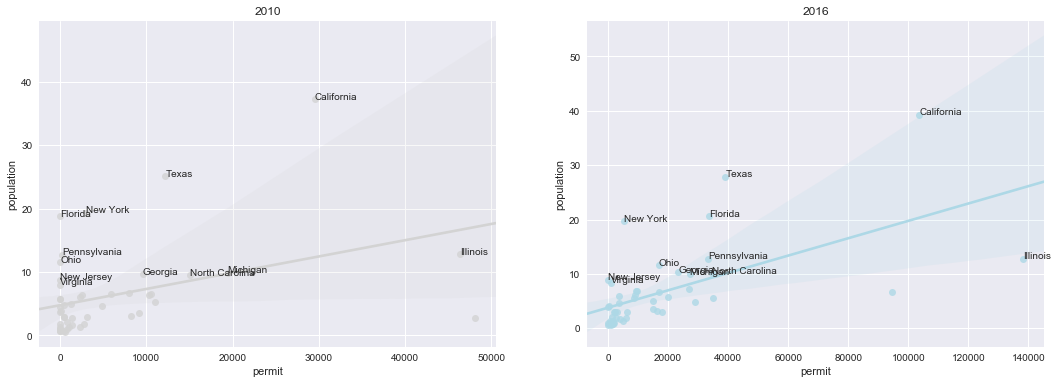

In [579]:
plot_scatter_ev(category='permit',remove_outlier=True)

<a id='conclusions'></a>
## Conclusions

The National Instant Criminal Background Check System (NICS), mandated by the Brady Handgun Violence Prevention Act (Brady Law) of 1993, has been launched by the Federal Bureau of Investigation (FBI) in 1998. 

Gun laws regulate the sale, possession and carry or firearm within US states. These laws are complex and present significant variations among states. Depending on state law, NICS background checks can take place:
- by a federal firearm licensed sellers to check the criminal background of the buyer when a transfer (firearm sale but also pawn/redemption, and return) takes place. This includes both handgun and long guns categories. 
- by a private seller for a firearm transfer
- by a state representative when delivering a permit of purchase 
- by a state representative when delivering a concealed carry permit

All background checks described above are not used by all states. For example, Hawaii delivers a permit of purchase for any type of firearm with an associated background check (permit category) and there won't be any check performed during transfer. At the opposite of the spectrum, Vermont will only perfom background cheks at firearm transfer by licensed sellers. Depending on state gun laws, all possible combinatories can be contemplated and they can vary with time with law changes.

During this analysis we've focused on the three main categories of NICS checks: permit, handgun and long_gun. Others categories have been either discarded or reallocated to these main categories because their contribution was rather negligible. In addition to these three main categoris, we've introduced the gun sales estimator used by NY times, which is roughly a linear combination of handgun and long_gun categories. This estimator can clearly be put into question as many sales are hidden by permit checks.

Four pathes have been explored during this analysis:
- Evolution of NICS checks since 1998 at country level
- Repartition of NICS checks at state level and identifcation of patterns
- Correlation of NICS checks with census data
- Normalized NICS checks and evolution between 2010 and 2016

The main observation on the **evolution of NICS cheks** is that the general trend is increasing since the introduction of NICS in 1998 with a steep acceleration since 2010. Actually, US population has increase from 2010 to 2016 of only 4.5% whereas the number of total checks has more than doubled for permit and handgun categories, and even long_gun category has increased of 20%. However a slight cool down can be observed for the very last year recorded. Beyond this main trend, some others observations are interesting:
- checks are very sensitive to seasonal variations (+40% by the end of the year)
- some peaks linked to key geopolitical events can be observed (9/11, Obama's election ...), a valuable interpretation of these peaks is proposed by the article of the NY times.
- the number of handgun checks is greater than lon guns checks since few years
- the growth of permit checks is beyond all others categories in particular since 2010. This observation reveals a growing adherence of all states to FBI background cheks for permit deliveries.
- the gap between gun sales estimator and totals checks increase with time as well, mainly because a lot of handgun sales are not leading to a background check as they are replaced by a permit delivery (either purchase or concealed carry)  

The study of ***patterns of NICS checks repartition at state level*** is a bit more tricky. Causality between the different FBI NICS background checks categories and gun laws are not straightforward but some outliers and most significant patterns can be extracted. Outliers can be revealed by ranking categories and concerns following states:
- Kentucky has the highest number of permit checks among all states. This state requires automatic monthly background checks on every holder of concealed-carry permits in the commonwealth, which as a direct impact on the total -an abnormal- volume.
- Hawaii has only permit checks records. This state delivers permit to acquire firearms (both handguns and long guns) and this is the only situation during which a FBI background check is performed.
- Pennsylvania has the highest number of long_gun checks among all states. Pattern is a rather difficult to explain, it looks like licensed sellers were identifying any firearm background check as long_gun before 2014.

After this preliminary analysis on outliers, we've introduced a synthetic scatter diagram depicting the repartition between checks among all states. As this diagram is key to interpretate different patterns and gun laws specificities, we've generated it below starting from 2015 (see below):

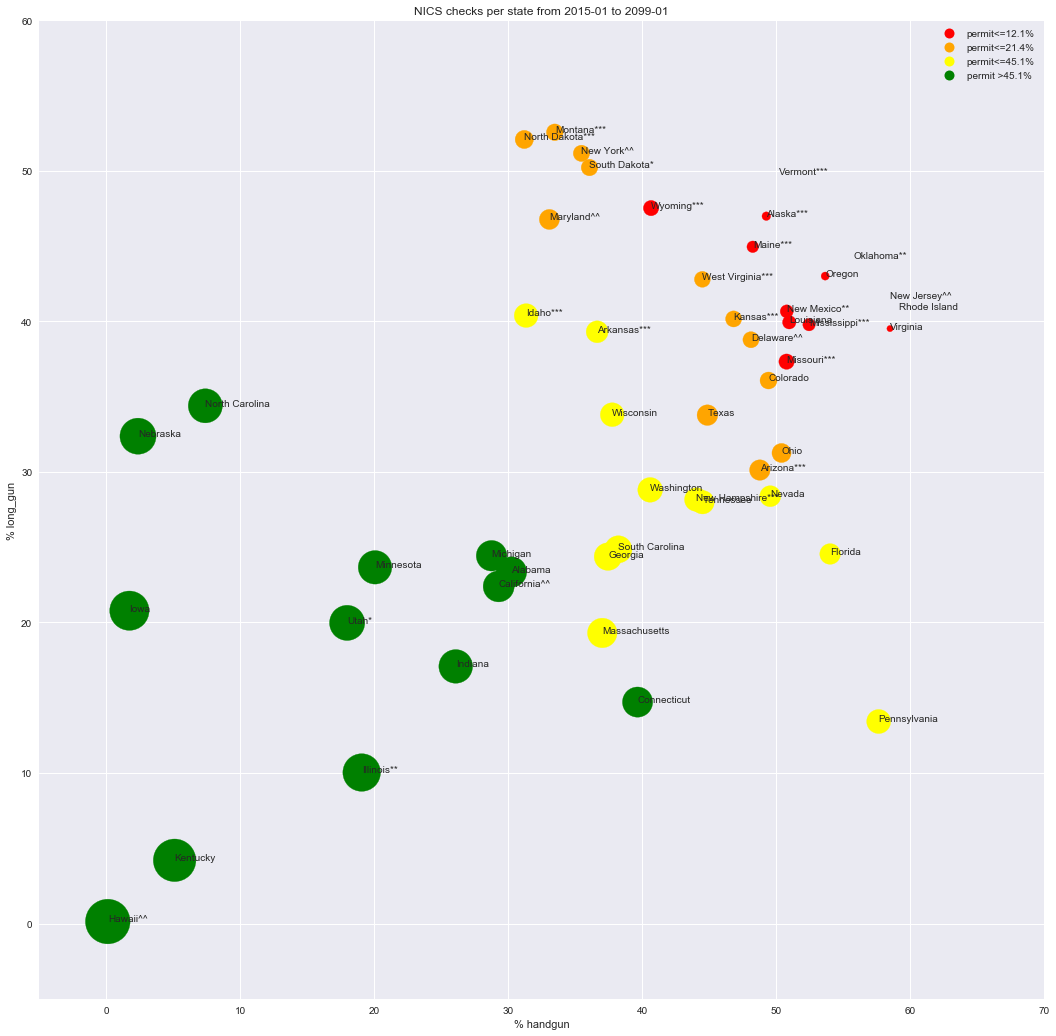

In [580]:
plot_scatter_map_us(gun_data_df,start_date='2015-01',xlim=70,ylim=60,figsize=(18,18))

- States without any permit records are located in the upper right part of the diagram: Vermont, Oklahoma, New Jersey and Rhode Island. For these states, background checks are only performed by licensed sellers on firearm transfer. However, this category doesn't always include permissive states. Actually New Jersey as a very restrictive gun policy. It is noteworhty that this category tends to disapear with time. **Most states now use background checks for delivery of concealed carry permits.**
- States with few permit records are identified with red dots. In general, these states have adopted background checks lately for delivery of concealed carry permit for reciprocity purpose with others states.
- At the opposite of the spectrum, on the left bottom part of the diagram, states with a massive number of permit checks are identified with green dots. In general these states have restrictive laws and background checks are required for concealed carry permit or/and for firearm purchase. A particular sub-category is states without or with few handgun checks, these states deliver a permit to purchase for handguns with a background check. It is noteworthy that NY times estimated gun sales doesn't work at all for this category of states.

We've also highlithed in this exploration the evolution of gun laws and its impact on background checks. For instance, above diagram will be different for a different period of time. But basically we retrieve trends identified in the time-serie at US level: permit and handgun checks increase drastically.

**Correlation with census data** throwed light upon the particularity of US demography which is balanced between a vast majority of states with few population and few states with a very important population: 75% of states are below 7.2 millions whereas California weights 39.2 millions. When correlation with NICS checks is calculated, the weigth of highly populated states (high z-score) is predominant. This particularity explains why the correlation of NICS background checks with population estimates is greater in 2016 than in 2010 (0.9 versus 0.65 for long_gun checks). For instance, California doubled the number of records in this category within 6 years which is more consistent with its population. As this state population is very high (high Z-score), the correlation to population estimate grows in 2016. This strengthening of correlation is illustrated by below plot for long gun category.  

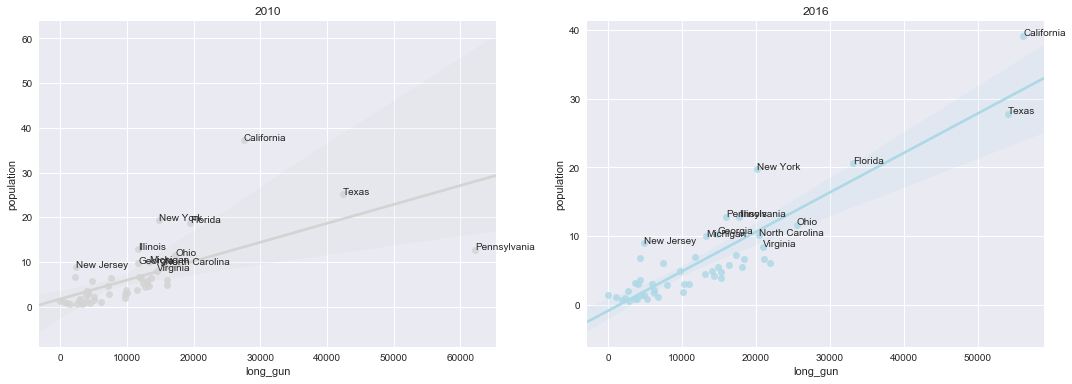

In [581]:
plot_scatter_ev(category='long_gun')

The rather strong correlation between handgun and long_gun cheks and Hispanic or Latino, percent, July 1, 2016, (V2016) or High school graduate or higher, percent of persons age 25 years+, 2011-2015 (negative correlation for this fact) can be explained the same way as main contributors are highly populated states, e.g Texas and California which have respectively a high percentage of hispanic population and a low proportion of high scool graduates compared to others states.

Othere noteworthy observation are following:
- permit category is poorly correlated to census facts. This category of checks is highly dependent of gun laws, which
is not at all correlated with the population estimates.
- long_gun checks are highly correlated to population estimates and many others census facts. As many census facts (such as housing units) are almost proportional to population size (which can be shown by calculating auto-correlation of census facts), we've only focused on population estimates and the two facts detailed in preceding §.
- hand_gun checks are slightly less correlated than long_gun cheks to population estimates. As highlighted by preceding exploration, hand gun checks can be superseded by permit checks in many states. Once again, specifities in gun laws tend to lower the correlation to population estimates.

Finnaly, we studied .**normalized NICS checks for 2010 and 2016**. Normalization allows to identify states with a high gun ownership, this is to say all states which have at the same time a high number of handgun and long_gun cheks per inhabitants (Wyoming, Alaska, Montana, South Dakota, West Virginia ...). These states allies permissive laws and gun culture. In addition,  contrary to previous representation based only on the ratio between categories, when checks are normalized, 'permissive' states are clearly clustered. This is the main added-value of this exploration, otherwise it mainly confirms trends and patterns which have already been identified previously. Most relevant confiramtion is the adoption by almost of all states of background checks for permit deliveries since a few years. Actually, stateswithout any background checks for permit delivery in 2016 are only a very few.


**
*This study throwed light upon the complexity of states gun laws among USA. It is rather hard (not to say impossible) to correlate NICS check records to states gun laws accurately. Nonetheless some interesting trends, outliers or specific patterns can be observed and some causality links with gun laws can be confirmed based on external sources. The most striking paradox observed in the general trend is the steady increase of hand gun sales compared to the will of states to control more permit deliveries through background checks. Accepting more guns ownership while trying to control who own or can carry it sounds a bit paranoid.
*
**

## Limitations
The main limitation of this study is that correlation between NICS checks and census facts has been performed on the whole sample, e.g without excluding any outliers or/and most populous states. There is a bias in the calculation of correlations and subsequent interpretations and conclusions:
- If we remove the most obvious outlier 'Kentucky' which has a high permit checks level, we obtain a better correlation for permits category. But it doesn't drastically change previous conclusions.
- if we discard as well most populous states (California, Texas, Florida and New York), we can see that correlations drops significantively for all checks categories.

Another important limitation of this analysis is that all causalities highlighted are based on obervations of time-series, checks repartition of checks per capita always coupled with an interpretation of state gun laws provided by external sources. From a strict mathematical standpoint nothing can be concluded in terms of causality between checks and gun laws based on these observations only.

Finally, private checks category has been discarded but it could have been studied more closely. 

<a id='summary'></a>
## Summary
- **Gun laws regulate the sale, possession an carry or firearm within US states. These laws are very complex and present significant variations among states. Depending on state law, NICS background checks can be used in a very different way.**
- **Number of NICS checks steadily increases since 1998 and with a steeper rate since 2010. In particular permit category has more than doubled since 2010 meanwhile population has increased by less than 5%. This reflects an increasing adherence of al states to NICS background checks for the delivery of purchase permit and/or concealed carry permit. **
- ** 'handgun' checks overcome 'long_gun' checks since a few years.**
- **'long_gun' and 'handgun' NICS checks are highly correlated to population estimates. Correlation between checks and population estimates grows from 2010 to 2016 mainly due to most populous states: California and Texas.**
- **'permit' checks evolution is more dependent on state gun laws specifities and is thus poorly correlated to population estimates.**
- ** some patterns can be deduced from checks repartition and ranking of checks normalized to population states, in particular following categoriesof states can be identified:**
    - **most permissive states: Wyoming, Alaska, Montana, South Dakota, West Virginia ...)**
    - **states delivering permits of purchase and/or concealed carry with background checks**
    - **states delivering permits of purchase for handguns with background checks**